# Εξόρυξη δεδομένων

Αλίκη Τσαμοπούλου Δαμιανή sdi1900193 \
Παναγιώτης Μαντάς sdi1400294
---

Η άσκηση έγινε με το VS code και python 3.10.14\
Η πιο συμαντική παραδοχή που πείραμε μετά απο συζήτη στο eclass είναι ότι στο αρχείο listings δεν υπάρχουν πολλαπλότυπα,\
πράγμα που στην πραγματικότητα δεν συμβαίνει καθώς ενώνοντας τα δεδομένα μέσα στο αρχείο μπορεί να υπάρχουν, 
διπλότυπα ή και πολλαπλότυπα.\
Αυτό έχει ως αποτέλεσμα να επηρεάζει την ακρίβεια των αποτελεσμάτων.

## Δήλωση βιβλιοθηκών

In [73]:
import pandas as pd
import numpy as np
import warnings
import csv
import matplotlib.pyplot as plt
from collections import Counter
from scipy.interpolate import interp1d
import folium
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math



warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)


## Προεπεξεργασία

#### Ένωση δεδομένων σε ενιαία δομή ανά έτος

#### Φόρτωση στη μνήμη

Φόρτωση listings:
Φτιάχνουμε και ένα αρχείο για την κάθε χρονιά και τον κάθε μήνα της μορφής (year_month_train.csb) σε περίπτωση που χρειαστούμε χωριστά τα δεδομένα αργότερα.

In [74]:
month_map = {
    "2019": ['april', 'febrouary', 'march'],
    "2023": ['june', 'march', 'september'],
}

complete_datasets = {
    "2019": [],
    "2023": []
}


for year, months in month_map.items():
    print(year, months)

    data_frames = []

    for month in months:
        file_path = f'{year}/{month}/listings.csv'
        df = pd.read_csv(file_path)
        df['month'] = month
        data_frames.append(df)
        print("Dimensions for " , file_path, " are " , df.shape)

        df.to_csv(f'output/{year}_{month}_listings.csv', index=False)

    complete_datasets[year] = pd.concat(data_frames, ignore_index=True)
    complete_datasets[year].reset_index(drop=True, inplace=True)

for year, dataset in complete_datasets.items():
    print("Dataset", year, "shape: ", complete_datasets[year].shape)

print("Data loaded")



2019 ['april', 'febrouary', 'march']
Dimensions for  2019/april/listings.csv  are  (9661, 107)
Dimensions for  2019/febrouary/listings.csv  are  (9100, 107)
Dimensions for  2019/march/listings.csv  are  (9361, 107)
2023 ['june', 'march', 'september']
Dimensions for  2023/june/listings.csv  are  (12345, 76)
Dimensions for  2023/march/listings.csv  are  (11382, 76)
Dimensions for  2023/september/listings.csv  are  (12955, 76)
Dataset 2019 shape:  (28122, 107)
Dataset 2023 shape:  (36682, 76)
Data loaded


Φόρτωση reviews:

In [75]:
reviews = {
    "2019": [],
    "2023": [],
}

file_path_2019 = f'2019/march/reviews.csv'
file_path_2023 = f'2023/september/reviews.csv'
    
reviews["2019"] = pd.read_csv(file_path_2019)
reviews["2023"] = pd.read_csv(file_path_2023)

for year in reviews.keys():
    reviews[year]['date'] = pd.to_datetime(reviews[year]['date'])

#### Φιλτράρισμα γνωρισμάτων
Στα δεδομένα περνάμε και την στήλη neighouhood_cleansed διότι σε αυτή την στήλη είναι ήδη καθαρισμένα τα δεδομένα.\
Φτιάχνουμε και το αρχείο που ζητήθηκε train_2019. \
Φτιάχνουμε και μια στήλη month για να μπορούμε αργότερα να ξέρουμε απο πιο μήνα προήλθαν τα δεδομένα.\

Στο πεδίο price αφαιρέσαμε το σύμβολο του δολλαρίου και αφαιρέσαμε το , ώστε να περάσει ως αριθμός στο panda και να μπορούμε να το χειριστούμε αναλόγος

In [76]:
filter_columns = {
    "2019": [
        'id', 'zipcode', 'transit', 'bedrooms', 'beds', 'review_scores_rating',
        'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude',
        'last_review', 'instant_bookable', 'host_since', 'host_response_rate',
        'host_identity_verified', 'host_has_profile_pic', 'first_review',
        'description', 'city', 'cancellation_policy', 'bed_type', 'bathrooms',
        'accommodates', 'amenities', 'room_type', 'property_type', 'price',
        'availability_365', 'minimum_nights', 'neighbourhood_cleansed', 'month'
    ],
    "2023": [
        'id', 'bedrooms', 'beds', 'review_scores_rating',
        'number_of_reviews', 'neighbourhood', 'name', 'latitude', 'longitude',
        'last_review', 'instant_bookable', 'host_since', 'host_response_rate',
        'host_identity_verified', 'host_has_profile_pic', 'first_review',
        'description', 'bathrooms',
        'accommodates', 'amenities', 'room_type', 'property_type', 'price',
        'availability_365', 'minimum_nights', 'neighbourhood_cleansed', 'month'
    ]
}

working_datasets = {
    "2019": [],
    "2023": []
}

for year, dataset in complete_datasets.items():
    working_datasets[year] = complete_datasets[year][filter_columns[year]]
    
    working_datasets[year].reset_index(drop=True, inplace=True)

    column_index = working_datasets[year].columns.get_loc('price')
    working_datasets[year].iloc[:, column_index] = working_datasets[year].iloc[:, column_index].str.replace('$', '').replace(',', '')
    working_datasets[year].iloc[:, column_index] = working_datasets[year].iloc[:, column_index].str.replace(',', '')
    working_datasets[year].loc[:, 'price'] = pd.to_numeric(working_datasets[year].loc[:, 'price'])

    print("Year", year, "Total columns: ", len(filter_columns[year]))
    print(working_datasets[year].shape)

    working_datasets[year].to_csv(f'output/train_{year}.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"', escapechar='\\', encoding="utf-8", index=False, doublequote=False)

print("Data saved to output")



Year 2019 Total columns:  32
(28122, 32)
Year 2023 Total columns:  27
(36682, 27)
Data saved to output


#### Dataset for the most listings

In [77]:
filter_columns = {
    "2019": [
        'host_name', 'host_id', 'host_listings_count'
    ],
    "2023": [
        'host_name', 'host_id', 'host_listings_count'
    ]
}

listings_datasets = {
    "2019": [],
    "2023": []
}

for year, dataset in complete_datasets.items():
    listings_datasets[year] = complete_datasets[year][filter_columns[year]]
    
    listings_datasets[year].reset_index(drop=True, inplace=True)

    column_index = listings_datasets[year].columns.get_loc('host_listings_count')
    listings_datasets[year].loc[:, 'host_listings_count'] = pd.to_numeric(listings_datasets[year].loc[:, 'host_listings_count'])
    # listings_datasets[year]['host_id'] = listings_datasets[year]['host_id'].astype(str)
    listings_datasets[year].loc[:, 'host_id'] = listings_datasets[year].loc[:, 'host_id'].astype(str)
    listings_datasets[year] = listings_datasets[year].drop_duplicates(subset='host_id')

    print(listings_datasets[year].shape)


    listings_datasets[year].to_csv(f'output/listings{year}.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='"', escapechar='\\', encoding="utf-8", index=False, doublequote=False)

print("Data saved to output")

(6062, 3)
(6330, 3)
Data saved to output


C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1508596921.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['37177' '37177' '37177' ... '248009293' '248009293' '147757642']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  listings_datasets[year].loc[:, 'host_id'] = listings_datasets[year].loc[:, 'host_id'].astype(str)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1508596921.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['37177' '37177' '37177' ... '293740243' '434609411' '14184069']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  listings_datasets[year].loc[:, 'host_id'] = listings_datasets[year].loc[:, 'host_id'].astype(str)


#### Κατανομή απουσίας τιμών στις πλειάδες

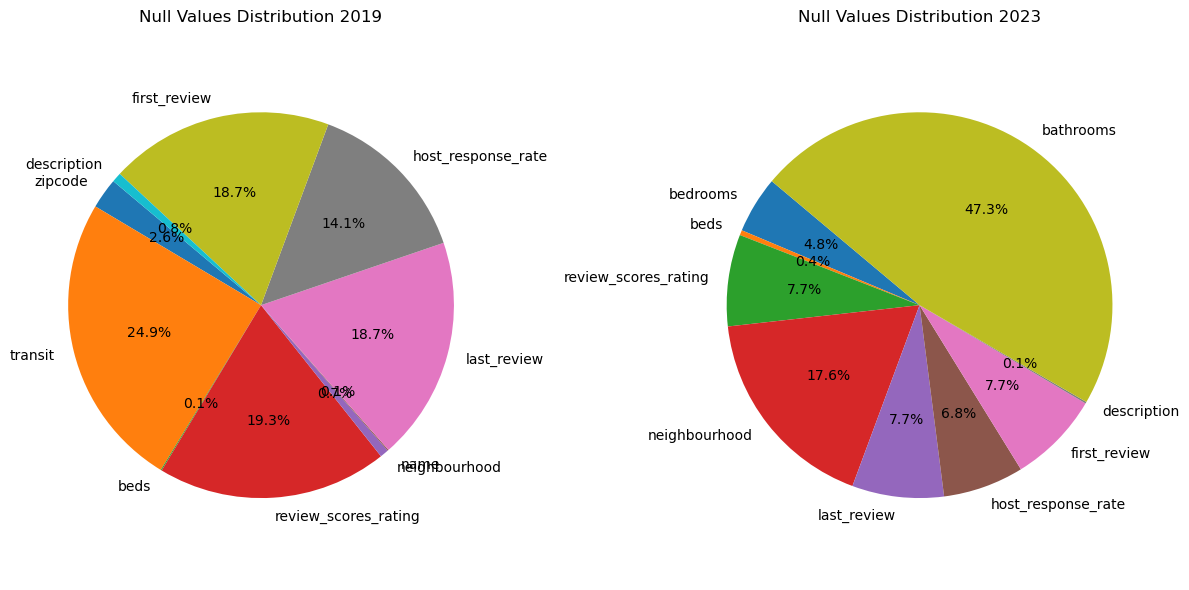

In [78]:

null_counts = {
    "2019": None,
    "2023": None
}

for year, dataset in working_datasets.items():
    null_counts[year] = dataset.isnull().sum()
    null_counts[year] = null_counts[year][null_counts[year] > 20]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

null_counts_df1 = null_counts["2019"]
null_counts_df2 = null_counts["2023"]

axs[0].pie(null_counts_df1, labels=null_counts_df1.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Null Values Distribution 2019')
axs[0].axis('equal')

axs[1].pie(null_counts_df2, labels=null_counts_df2.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Null Values Distribution 2023')
axs[1].axis('equal')

plt.tight_layout()
plt.show()


## Exercises

#### (1.1) Most frequent room type

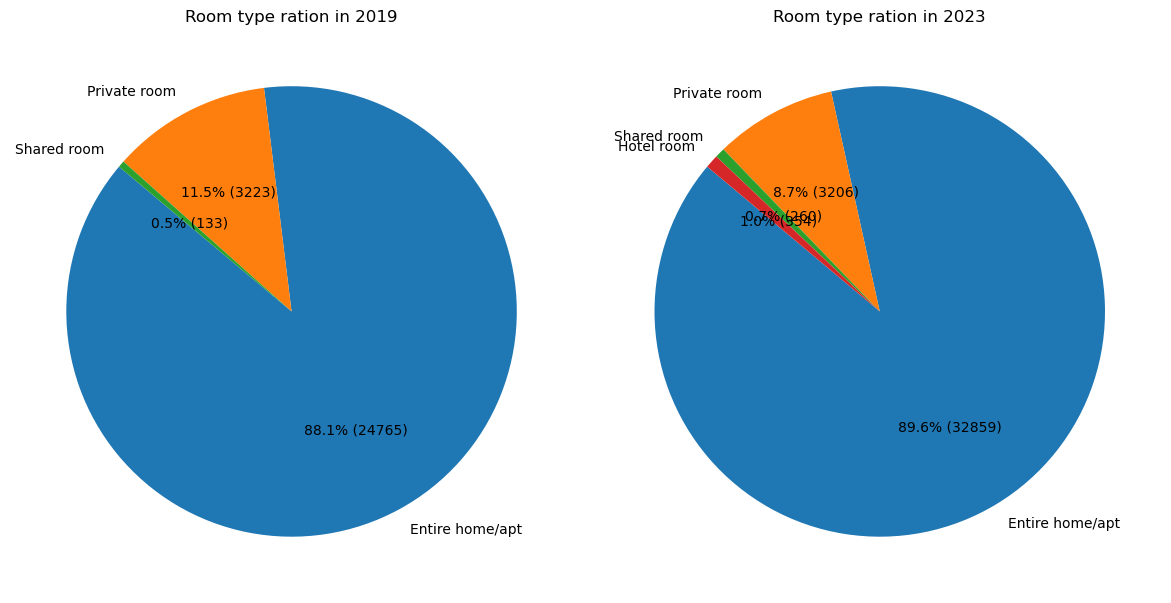

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for year, dataset in working_datasets.items():
    series = working_datasets[year]['room_type']
    c = Counter(series)

    values = list(c.keys())
    frequencies = list(c.values())

    axs[i].pie(frequencies, labels=values, autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(frequencies))})", startangle=140)
    axs[i].set_title('Room type ration in ' + str(year))

    i=i+1

plt.tight_layout()
plt.show()



#### (1.2) Average price per month

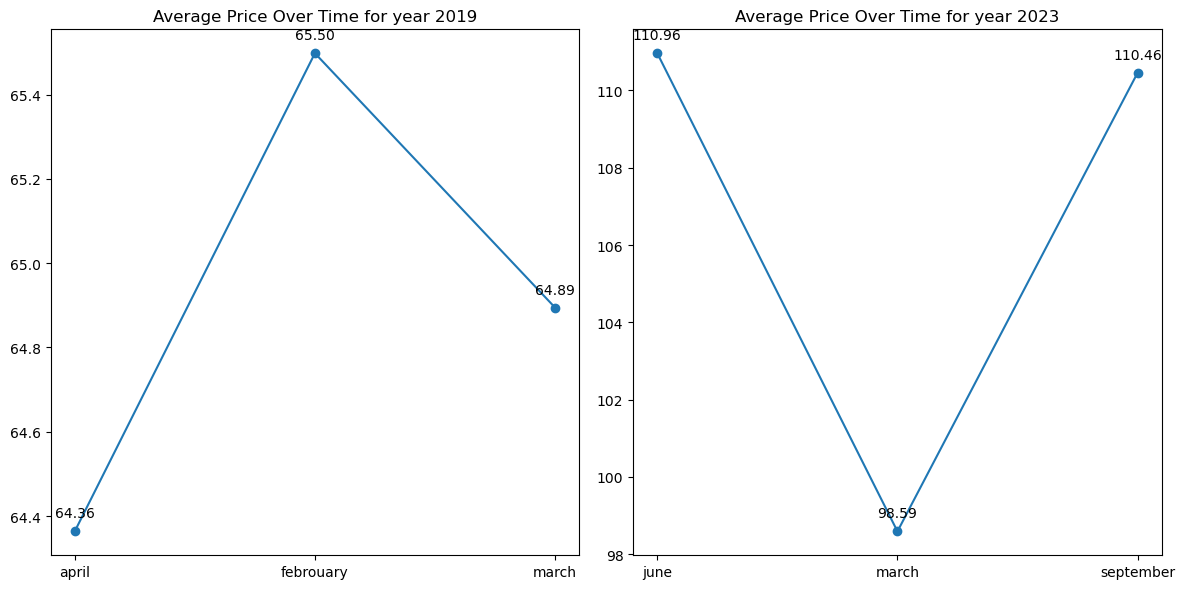

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for year, dataset in working_datasets.items():
    df = working_datasets[year][['month', 'price']].groupby('month')['price'].mean().reset_index()

    axs[i].plot(df['month'], df['price'], marker='o', linestyle='-')
    axs[i].set_title('Average Price Over Time for year ' + str(year))

    for x, y in zip(df['month'], df['price']):
        axs[i].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')


    i=i+1

plt.tight_layout()
plt.show()


#### (1.3) Top 5 neighborhoods with the most ratings

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\179651662.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['neighbourhood_cleansed'], rotation=70)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\179651662.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['neighbourhood_cleansed'], rotation=70)


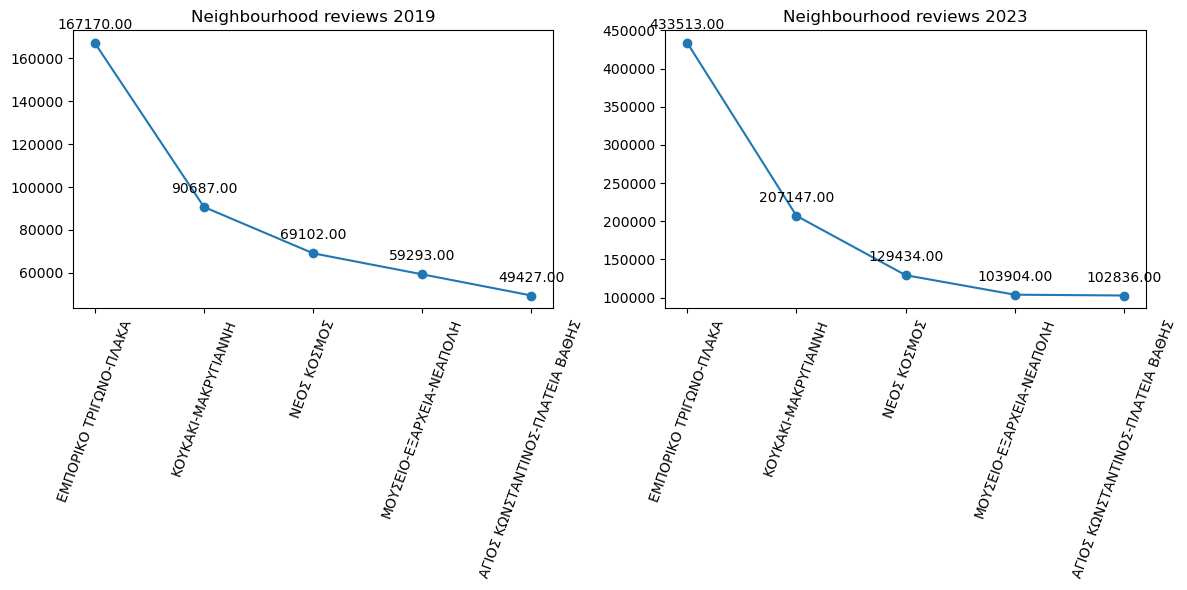

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for year, dataset in working_datasets.items():
    df = working_datasets[year][['neighbourhood_cleansed', 'number_of_reviews']].groupby('neighbourhood_cleansed')['number_of_reviews'].sum().reset_index()
    df = df.sort_values(by='neighbourhood_cleansed').nlargest(5, 'number_of_reviews')

    axs[i].plot(df['neighbourhood_cleansed'], df['number_of_reviews'], marker='o')
    axs[i].set_title('Neighbourhood reviews ' + str(year))
    axs[i].set_xticklabels(df['neighbourhood_cleansed'], rotation=70)

    for x, y in zip(df['neighbourhood_cleansed'], df['number_of_reviews']):
        axs[i].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    i=i+1

plt.tight_layout()
plt.show()

#### (1.4) Top 5 neighborhoods with the most listings

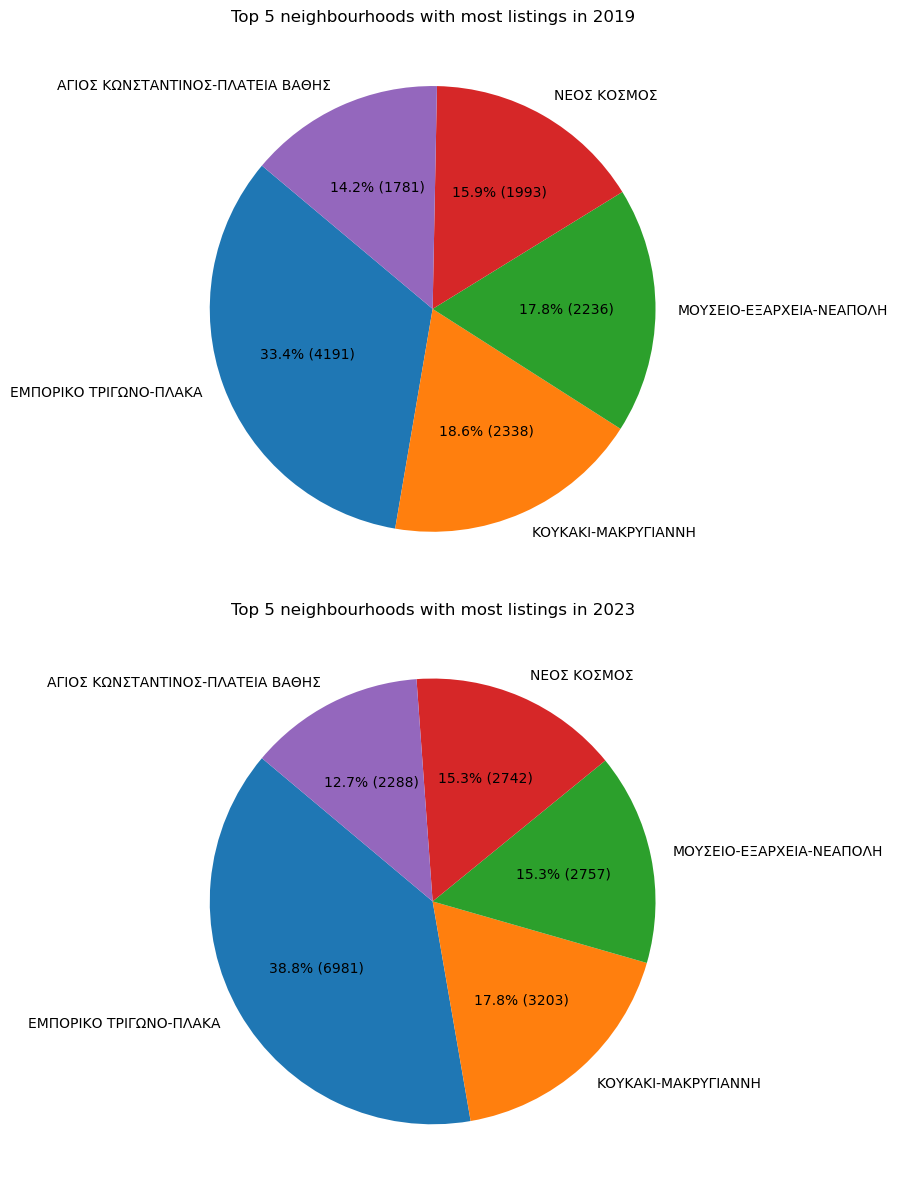

In [82]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

i = 0
for year, dataset in working_datasets.items():
    series = working_datasets[year]['neighbourhood_cleansed']
    c = Counter(series)

    top_5 = c.most_common(5)
    values = [item[0] for item in top_5]
    frequencies = [item[1] for item in top_5]

    axs[i].pie(frequencies, labels=values, autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(frequencies))})", startangle=140)
    axs[i].set_title('Top 5 neighbourhoods with most listings in ' + str(year))

    i=i+1

plt.tight_layout()
plt.show()

#### (1.5,1.6) Neighborhood-month listings, histogram
Με βάση το παράδειγμα που μας δόθηκε στις συζητήσεις στο eclass αυτά τα 2 ερωτήματα τα απαντάμε μαζί 

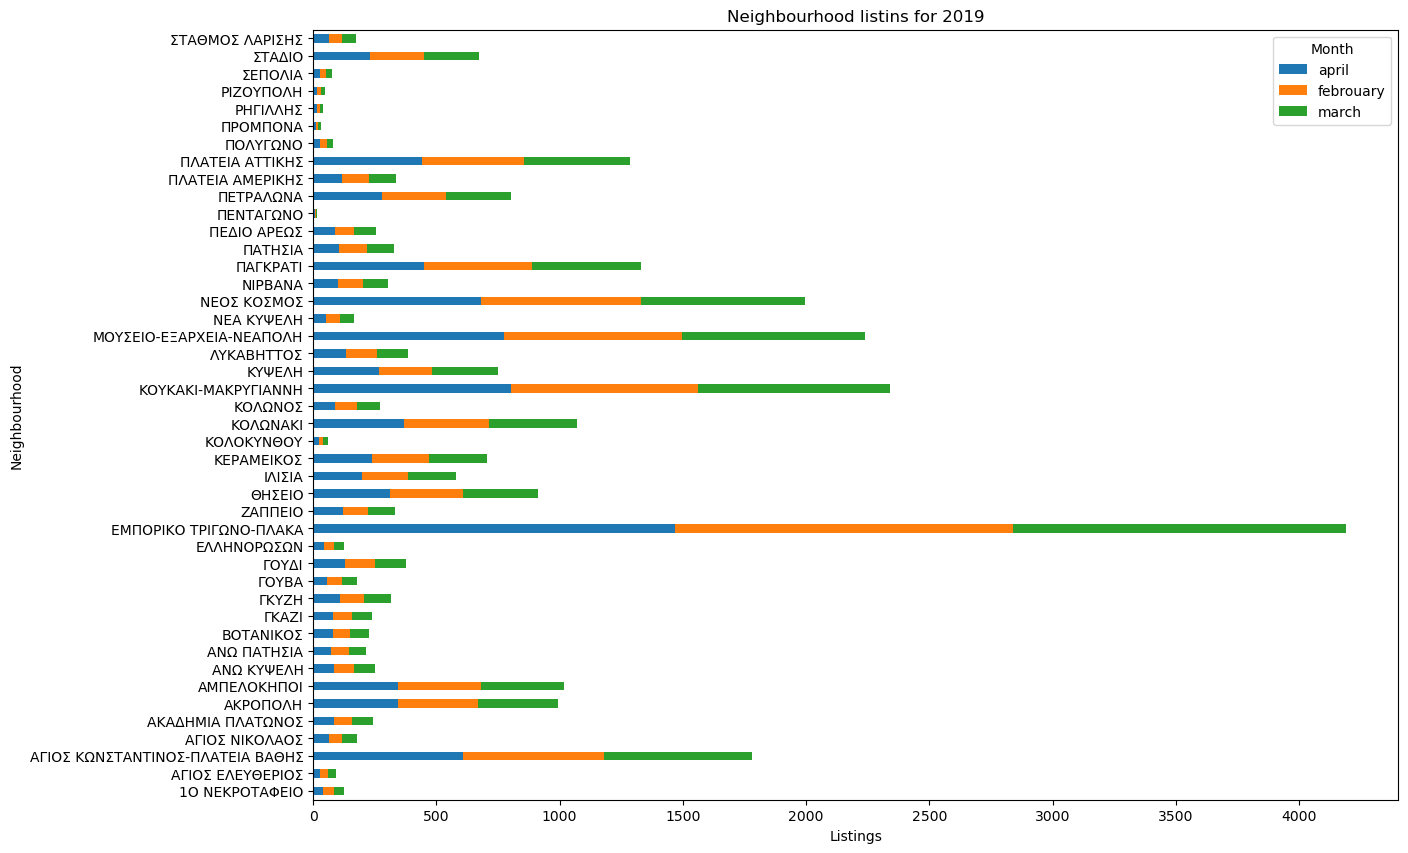

In [83]:
year = '2019'
df = working_datasets[year][['neighbourhood_cleansed', 'month']].groupby(['neighbourhood_cleansed', 'month']).size().reset_index(name='count')

df = df.pivot(index='neighbourhood_cleansed', columns='month', values='count').fillna(0)

df.plot(kind='barh', stacked=True, figsize=(14, 10))
plt.xlabel('Listings')
plt.ylabel('Neighbourhood')
plt.title('Neighbourhood listins for 2019')
plt.legend(title='Month')
plt.show()

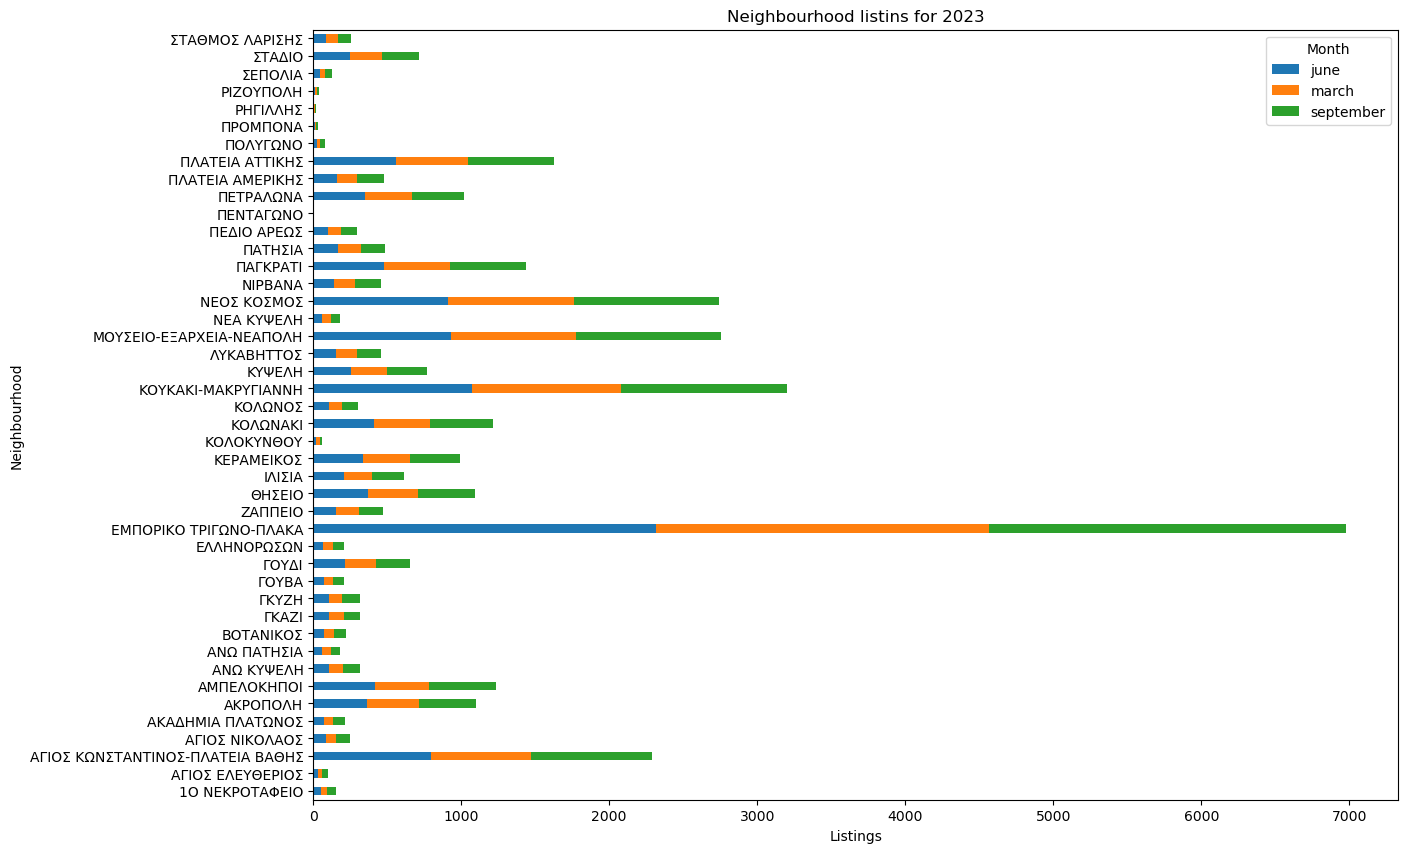

In [84]:
year = '2023'
df = working_datasets[year][['neighbourhood_cleansed', 'month']].groupby(['neighbourhood_cleansed', 'month']).size().reset_index(name='count')

df = df.pivot(index='neighbourhood_cleansed', columns='month', values='count').fillna(0)

df.plot(kind='barh', stacked=True, figsize=(14, 10))
plt.xlabel('Listings')
plt.ylabel('Neighbourhood')
plt.title('Neighbourhood listins for 2023')
plt.legend(title='Month')
plt.show()

#### (1.7)  Most common appartment type per neighborhood

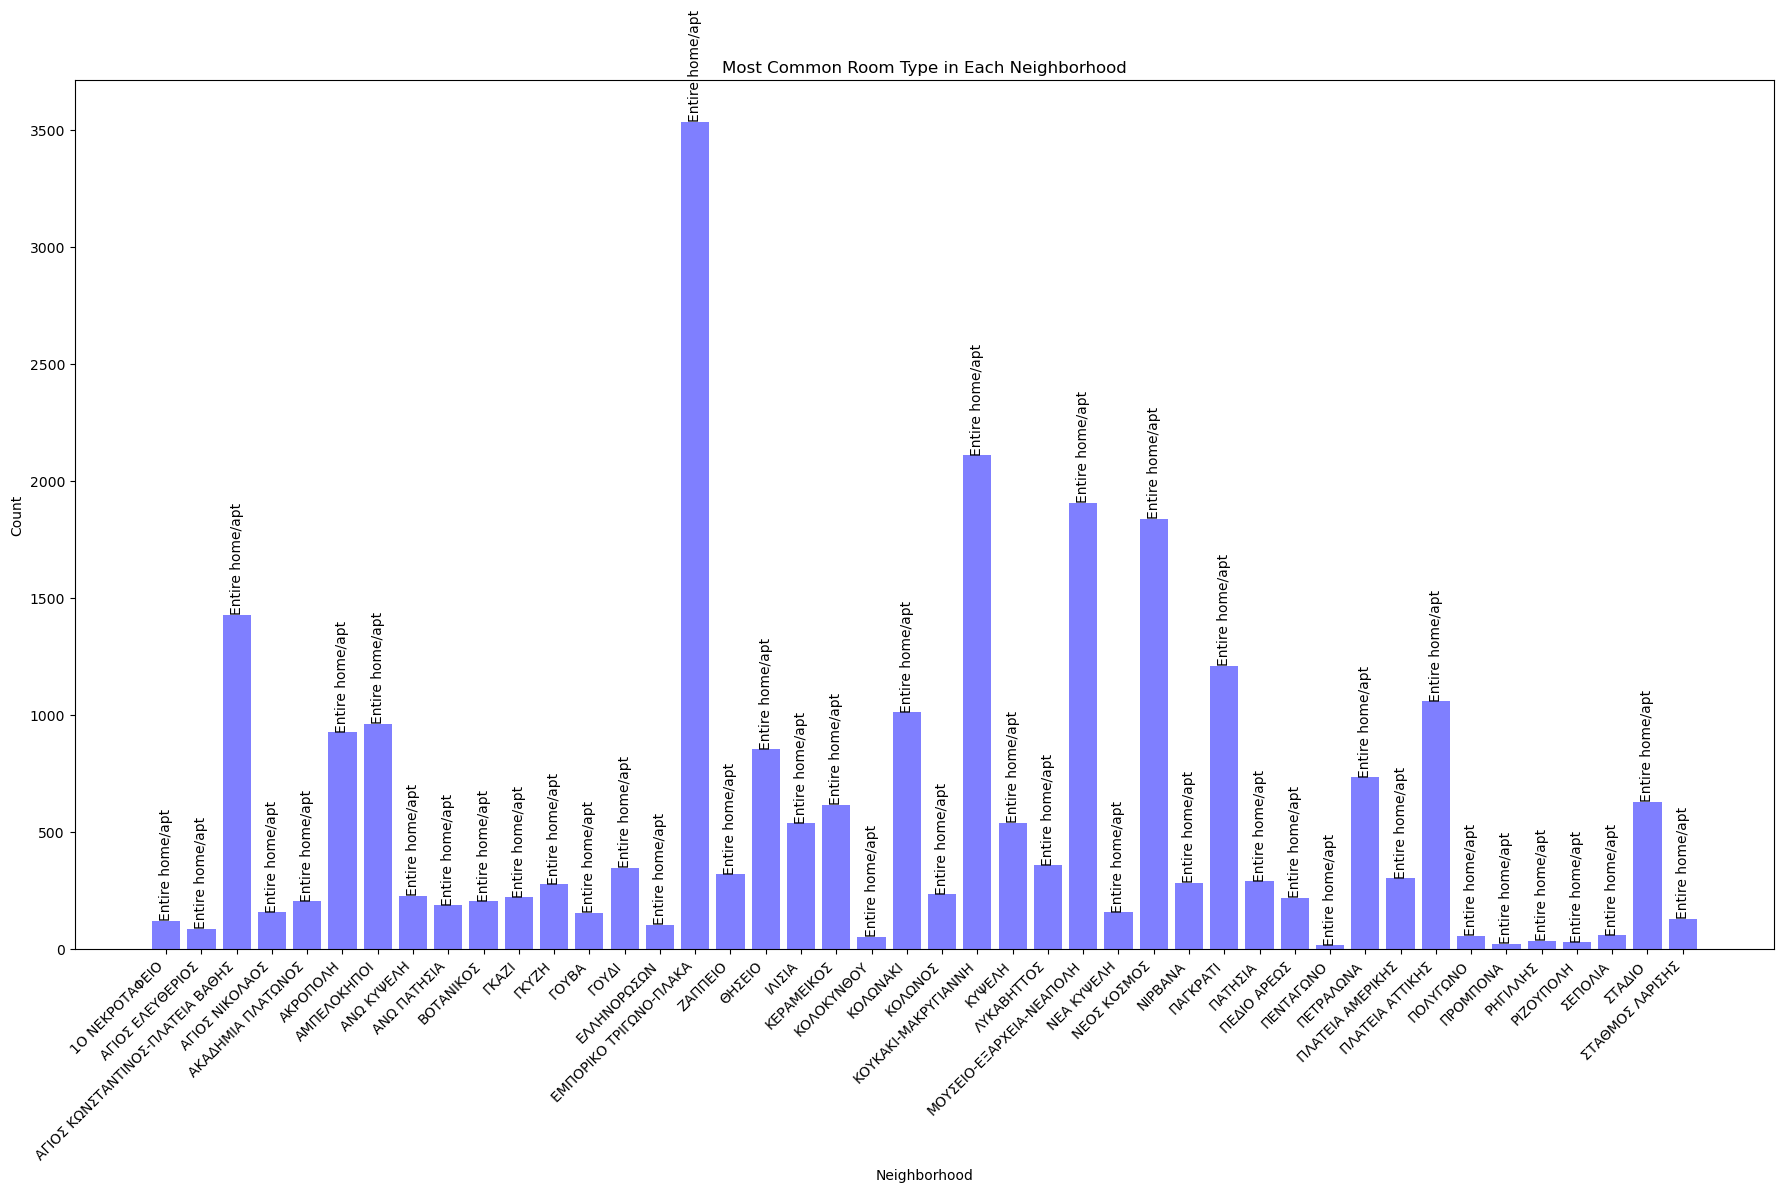

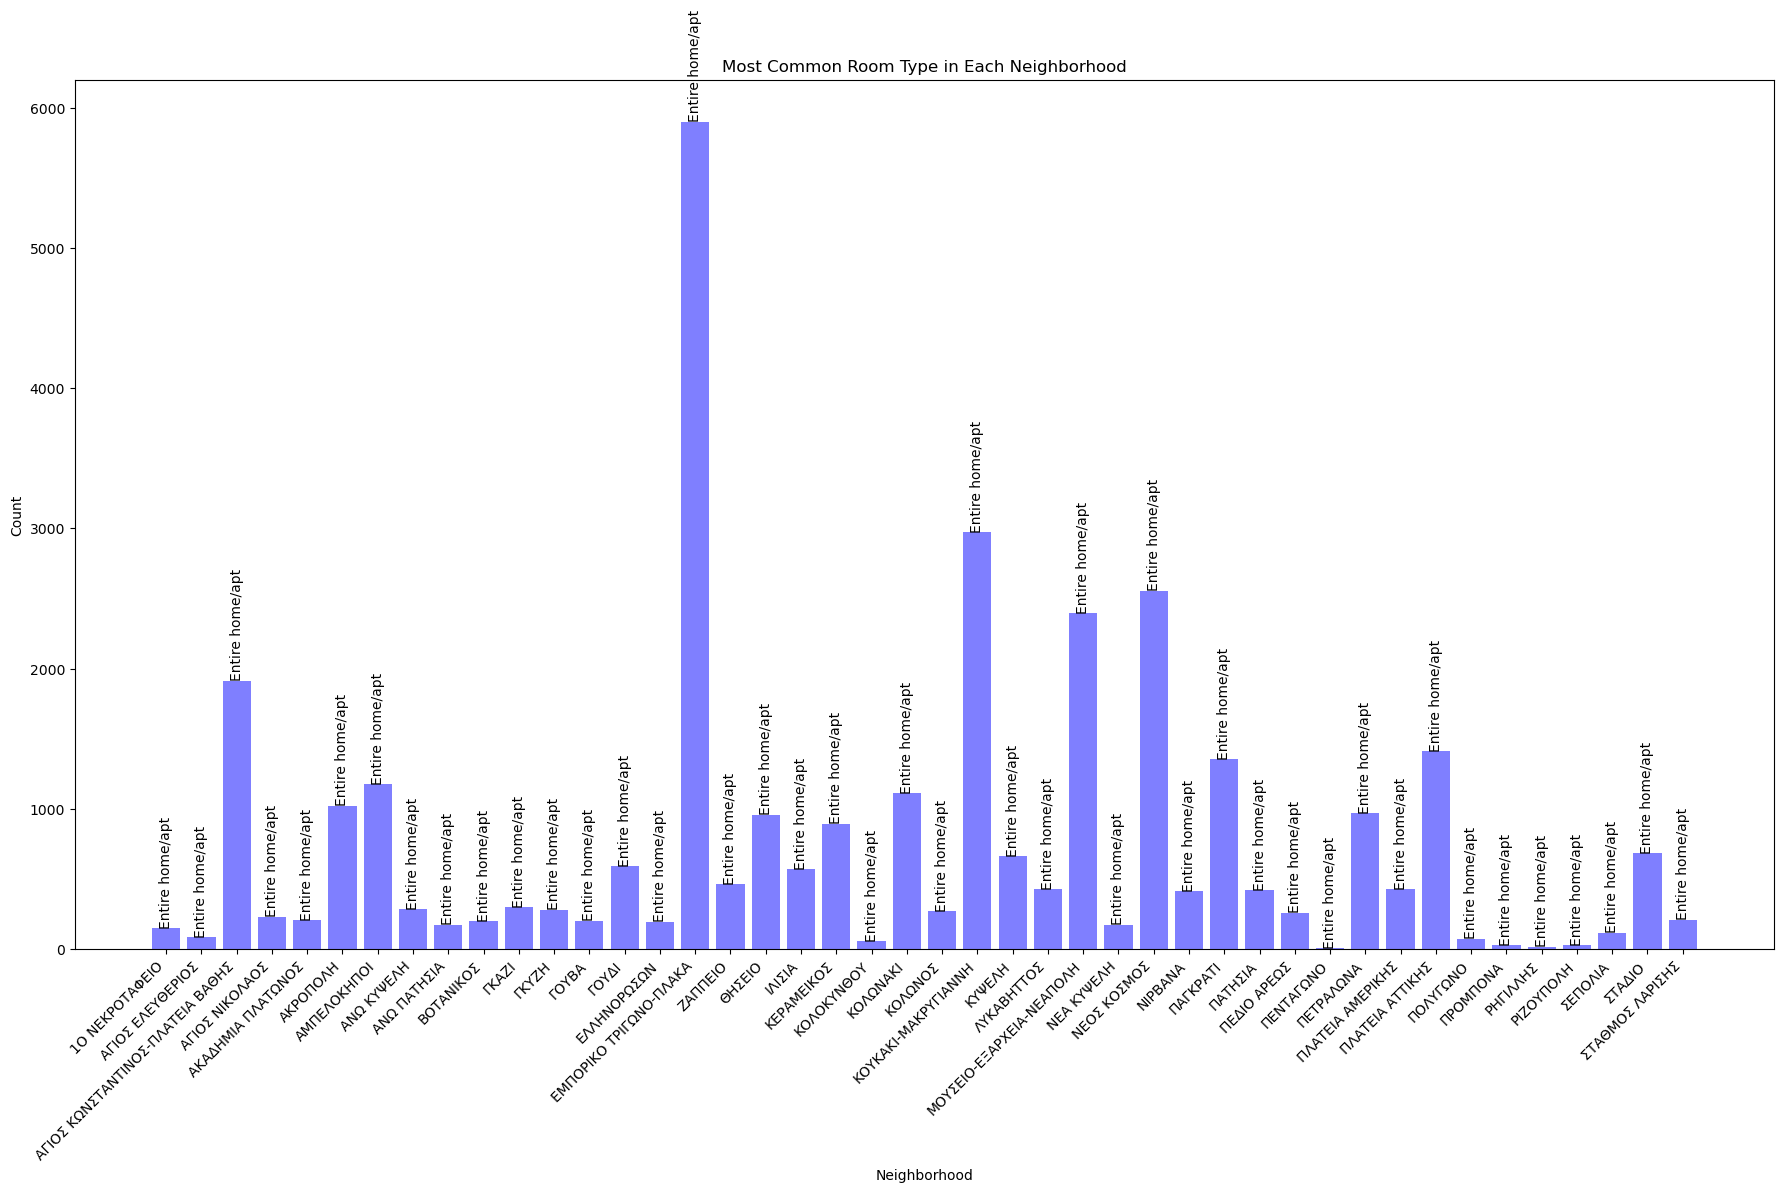

In [85]:

for year, dataset in working_datasets.items():
    df = working_datasets[year].groupby(['neighbourhood_cleansed', 'room_type']).size().reset_index(name='count')
    most_common_room_types = df.loc[df.groupby('neighbourhood_cleansed')['count'].idxmax()]
    most_common_room_types

    plt.figure(figsize=(18, 12))
    for index, row in most_common_room_types.iterrows():
        plt.bar(row['neighbourhood_cleansed'], row['count'], color='blue', alpha=0.5)
        plt.text(row['neighbourhood_cleansed'], row['count'] + 0.5, row['room_type'], ha='center', va='bottom', rotation=90)

    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.title('Most Common Room Type in Each Neighborhood')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### (1.8)  Most expensive room type

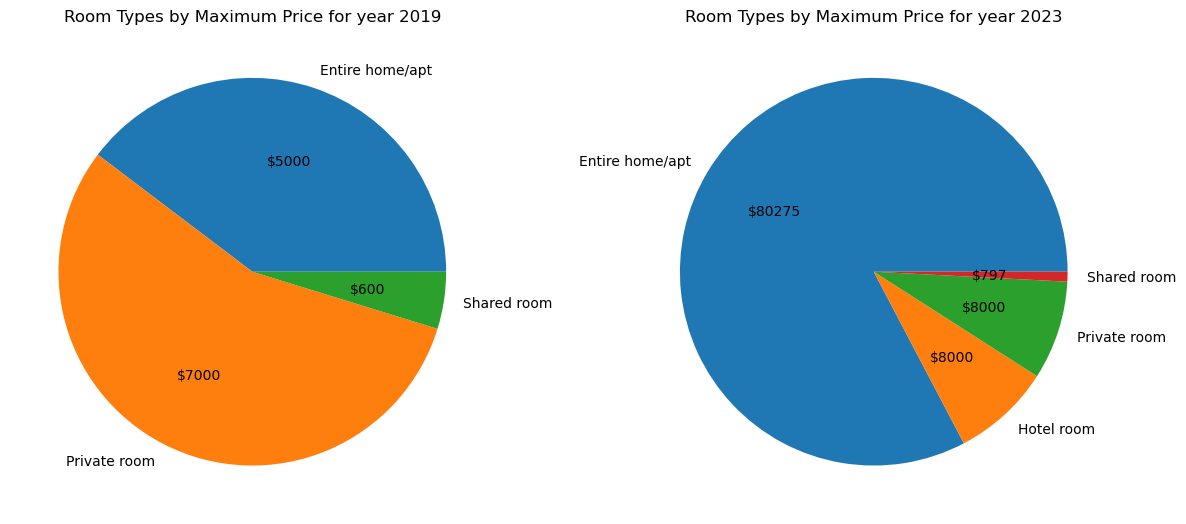

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for year, dataset in working_datasets.items():
    df = working_datasets[year].groupby('room_type')['price'].max()


    axs[i].pie(df, labels=df.index, autopct=lambda p: '${:.0f}'.format(p * sum(df) / 100))
    axs[i].set_title('Room Types by Maximum Price for year '+ str(year))
    i=i+1

plt.tight_layout()
plt.show()



# year = "2019"
# df = working_datasets[year].groupby('room_type')['price'].max()
# plt.figure(figsize=(8, 8))
# plt.pie(df, labels=df.index, autopct=lambda p: '${:.0f}'.format(p * sum(df) / 100))
# plt.title('Room Types by Maximum Price')
# plt.show()


#### (1.9)  Folium show listing on te map with Folium
Επειδή τα δεδομένα είναι πάρα πολλά στο χάρτη εμφανίζουμε μόνο τα 20 απο τα αποτελέσματα του Dataset μας.\
Έχει δοκιμάστεί και λειτουργεί και με όλα τα ποτελέσματα όμως καταναλώνει αρκετή μνήμη και είναι δίσκολο,\
ο υπολογιστής να κάνει render το αποτέλεσμα.
έχουμε αφήσει σε σχόλιο και την γραμμή 3 για να φορτώσουν όλα

In [87]:
year = "2019"
df = working_datasets[year][working_datasets[year]['month'] == 'april'][:20] # comment this line if you want to load all the listing on the map
# df = working_datasets[year][working_datasets[year]['month'] == 'april'] # uncomment this line if you want to load all the listing on the map

mymap = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=15)

# Add markers for each location
for index, row in df.iterrows():
    popup_text = f"Room Type: {row['room_type']}"
    folium.Marker([row['latitude'], row['longitude']], popup=popup_text).add_to(mymap)

# Display the map
mymap


#### (1.10)  Word clouds for neighbourhood, tranist, description, last_review
Στα δεδομένα υπήρχαν πολλά html tags οπότε με ένα regular expression τα αφαιρέσαμε.\
Θεωρίσαμε σωστό να αφαιρέσουμε τα stop words για μεγαλύτερη ακρίβεια στο αποτέλσμα πριν δούμε οτι ζειτήτε\
αυτό σε επόμενο ερώτημα στο δεύτερο κομμάτι της εργασία.

##### Neighbourhood

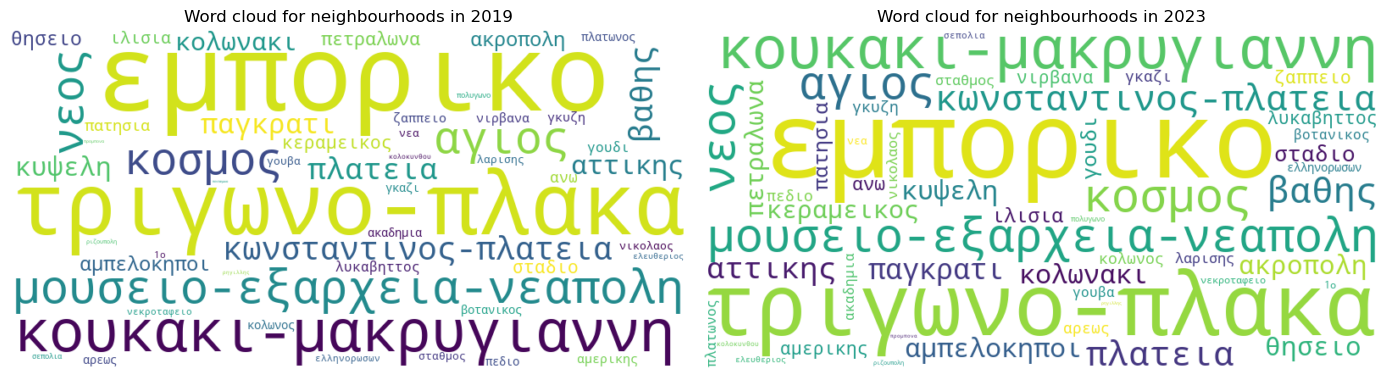

In [88]:

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
CLEANR = re.compile('<.*?>') 
wordclouds = {
    "2019": None,
    "2023": None
}

i = 0
for year, dataset in working_datasets.items():
    entries = [r for r in working_datasets[year]["neighbourhood_cleansed"] if r != None]
    entries = [re.sub(CLEANR, '', r) for r in entries if r != None]
    entries = [r.lower().split() for r in entries if r != None] 
    entries = [r for sublist in entries for r in sublist if r.lower() not in STOPWORDS]
    word_counter = Counter(entries)
    wordclouds[year] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

    axs[i].set_title("Word cloud for neighbourhoods in " + str(year))
    axs[i].imshow(wordclouds[year], interpolation='bilinear')
    axs[i].axis('off')

    i=i+1

plt.tight_layout()
plt.show()

Τυπώνουμε το ιστόγραμμά για να ελέγξουμε ότι το wordcloud εμαφνίζει πάνω κάτω τα δεδομένα που περιμένουμε\
η χρήση του ήταν πιο πολύ το debbuging

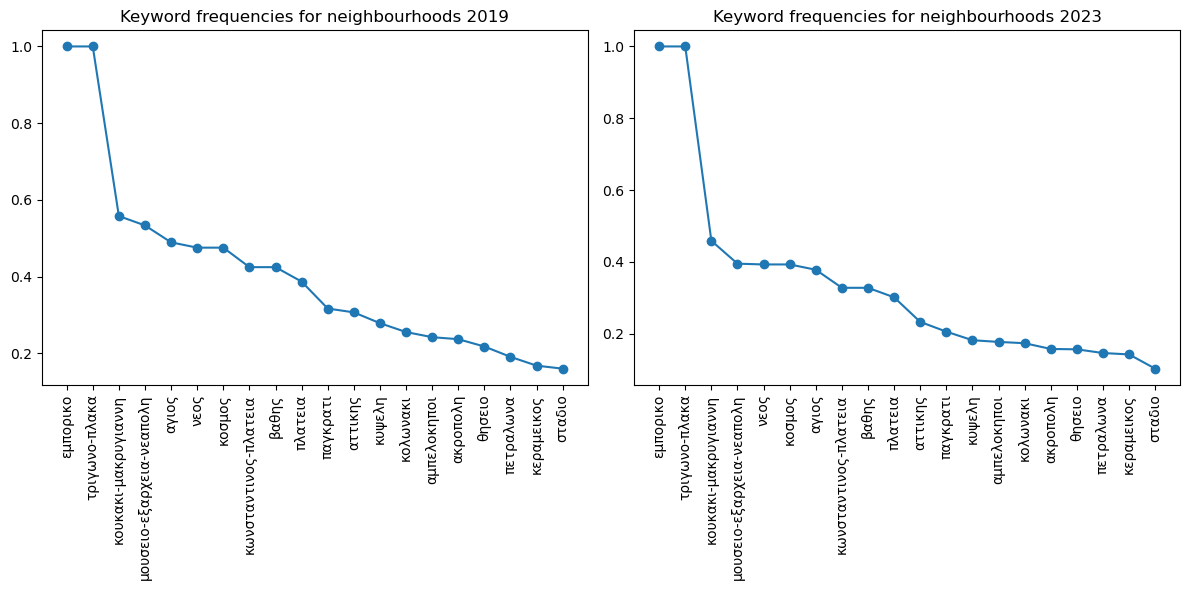

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

i = 0
for year in wordclouds.keys():
    wordcloud = wordclouds[year]
    word_frequencies = wordcloud.words_

    sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(sorted_word_frequencies[:20], columns=['Keyword', 'Frequency'])

    df.set_index('Keyword', inplace=True)

    axs[i].plot(df.index, df['Frequency'], marker='o')
    axs[i].set_title('Keyword frequencies for neighbourhoods ' + str(year))
    axs[i].xaxis.set_ticks(df.index)
    axs[i].set_xticklabels(df.index, rotation=90)

    i=i+1

plt.tight_layout()
plt.show()

##### Transit
Η στήλη transit δεν εμφανίζεται στα δεδομένα του 2023 οπότε φτιάξαμε μόνο για το έτος 2019

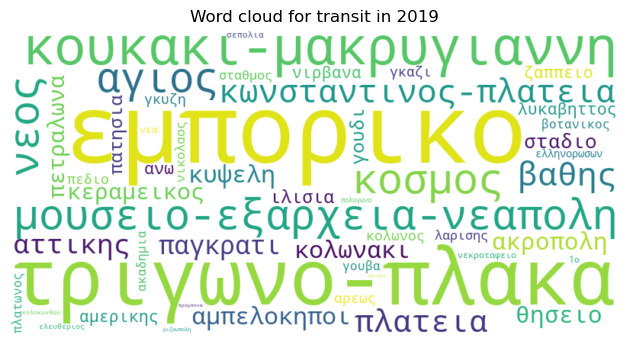

In [90]:
year = "2019"
CLEANR = re.compile('<.*?>') 

entries = [str(r).replace("-", " ") for r in working_datasets[year]["transit"] if r != None]
entries = [re.sub(CLEANR, '', r) for r in entries if r != None]
entries = [r.lower().split() for r in entries if r != None] 
entries = [r for sublist in entries for r in sublist if r.lower() not in STOPWORDS]
word_counter = Counter(entries)
wordclouds[year] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud for transit in " + str(year))
plt.tight_layout()
plt.show()



##### Description

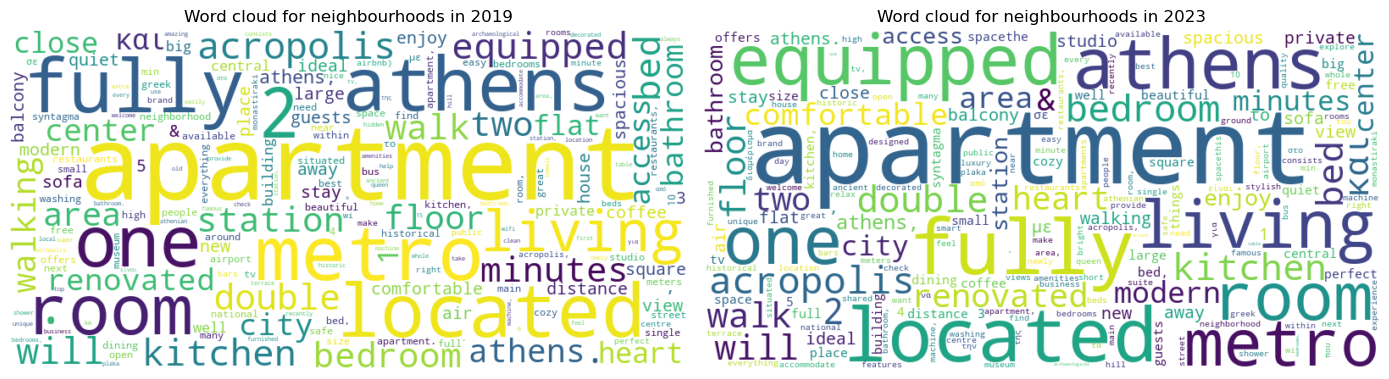

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
CLEANR = re.compile('<.*?>') 

i = 0
for year, dataset in working_datasets.items():
    entries = [str(r).replace("-", " ") for r in working_datasets[year]["description"] if r != None]
    entries = [re.sub(CLEANR, '', r) for r in entries if r != None]
    entries = [r.lower().split() for r in entries if r != None] 
    entries = [r for sublist in entries for r in sublist if r.lower() not in STOPWORDS]
    word_counter = Counter(entries)
    wordclouds[year] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

    axs[i].set_title("Word cloud for neighbourhoods in " + str(year))
    axs[i].imshow(wordclouds[year], interpolation='bilinear')
    axs[i].axis('off')

    i=i+1

plt.tight_layout()
plt.show()

##### Last review
Μιας και η εκφώνηση ζητάει το last review πείραμε μόνο το τελευταίο review του τελευταίο μήνα για το κάθε listing\
μια και μπορεί να υπάρχει μόνο ένα last review.

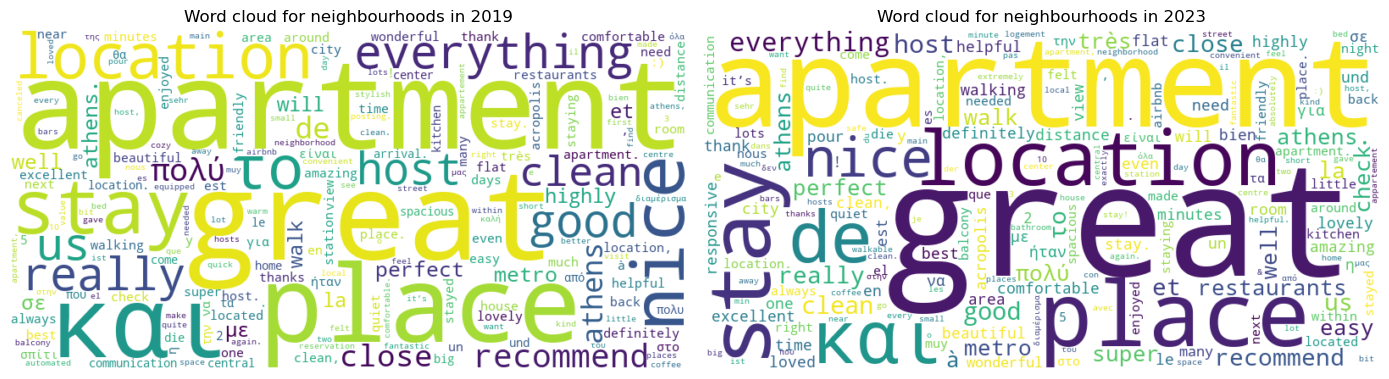

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
CLEANR = re.compile('<.*?>') 

i = 0
for year, dataset in working_datasets.items():
    df = reviews[year][["listing_id", "date", "comments"]]
    df = df.sort_values(by=['listing_id', 'date'], ascending=[True, False])
    df = df.drop_duplicates(subset='listing_id', keep='first')
    df = df.reset_index(drop=True) 

    entries = [str(r).replace("-", " ") for r in df["comments"] if r != None]
    entries = [re.sub(CLEANR, '', r) for r in entries if r != None]
    entries = [r.lower().split() for r in entries if r != None] 
    entries = [r for sublist in entries for r in sublist if r.lower() not in STOPWORDS]
    word_counter = Counter(entries)
    wordclouds[year] = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

    axs[i].set_title("Word cloud for neighbourhoods in " + str(year))
    axs[i].imshow(wordclouds[year], interpolation='bilinear')
    axs[i].axis('off')

    i=i+1

plt.tight_layout()
plt.show()

### (1.11)  Print unique amenities and replace with fewer categories

#### Print unique amenities
Πέρα απο τα unique amenities εμφανίζουμε και τις φορές που εμφανίζετε ώστε να μπορούμε να τα αντικαταστήμουμε τα πιο συμαντικά στο επόμενο κομμάτι του ερωτήματος.

In [93]:
year = "2019"
df = working_datasets[year].reset_index()
df['amenities'] = df['amenities'].str.replace('{', '').str.replace('}', '').str.strip()
df['amenities'] = df['amenities'].str.split(',')
df = df.explode('amenities')
df['amenities'] = df['amenities'].str.strip()
df['amenities'] = df['amenities'].str.strip().str.replace('"', '')
value_counts = df['amenities'].value_counts()
print(value_counts.shape)
print(value_counts[:20])




(186,)
amenities
Wifi                         26998
Essentials                   26893
Kitchen                      26248
Air conditioning             25629
Hangers                      25604
Hair dryer                   24875
Shampoo                      24197
Heating                      23954
TV                           23626
Iron                         23182
Laptop friendly workspace    20002
Elevator                     19230
Washer                       19022
Hot water                    18741
Refrigerator                 15470
Step-free access             14417
Dishes and silverware        14380
Cooking basics               14231
First aid kit                14069
Coffee maker                 13531
Name: count, dtype: int64


#### Replace amenities


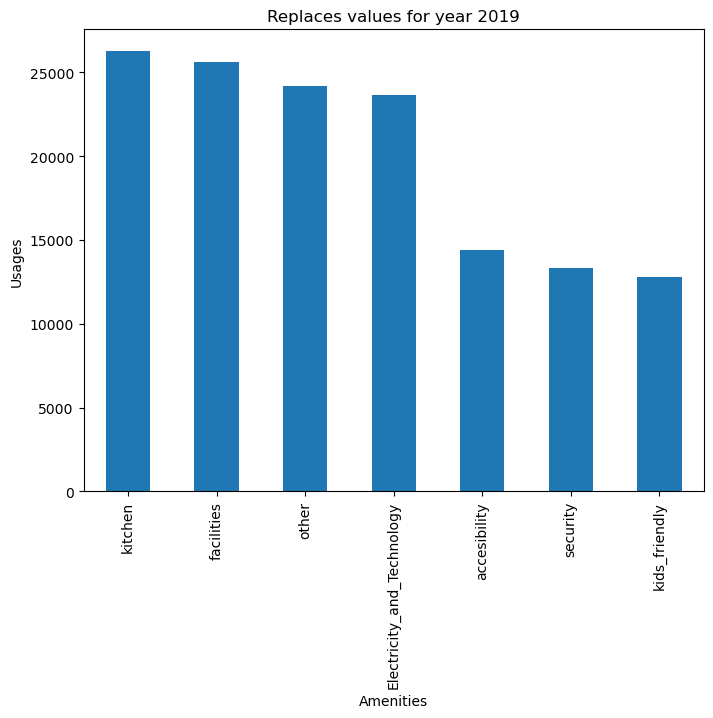

In [94]:
year = "2019"
replacement_dict = {
    'Kitchen': 'kitchen',
    'Refrigerator': 'kitchen',
    'Dishes and silverware': 'kitchen',
    'Cooking basics': 'kitchen',
    '"Coffee maker"': 'kitchen',
    '"Dishes and silverware"': 'kitchen',
    '"Cooking basics"': 'kitchen',
    'Oven': 'kitchen',
    'Microwave': 'kitchen',
    'Washer': 'kitchen',
    'Step-free access': 'accesibility',
    'TV': 'Electricity_and_Technology',
    'Wifi': 'Electricity_and_Technology',
    '"Air conditioning"': 'Electricity_and_Technology',
    'Hangers': 'facilities',
    '"Hair dryer"': 'facilities',
    'Heating': 'facilities',
    '"Laptop friendly workspace"': 'facilities',
    'Elevator': 'facilities',
    '"Hot water"': 'facilities',
    'Free street parking': 'facilities',
    'Internet': 'facilities',
    '"Family/kid friendly"': 'kids_friendly',
    '"Fire extinguisher"': 'security',
    '"Smoke detector"': 'security',
    '"Long term stays allowed"': 'services',
    '"Host greets you"': 'services',
    '"Luggage dropoff allowed"': 'services',
    '"Paid parking off premises"': 'services',
    'Free street parking': 'services',
    'Shampoo': 'other',
    'Iron': 'other',
    '"First aid kit"': 'other',
    '"Bed linens"': 'other',
    'Essentials': 'other',
    # Add more replacements as needed
}
df = working_datasets[year].reset_index()
replaced_words = set()
# df['amenities'] = df['amenities'].str.replace('"', '')
# Replace multiple words with one word in the column
for word, replacement in replacement_dict.items():
    if replacement not in replaced_words:
        df['amenities'] = df['amenities'].str.replace(word, replacement)
        replaced_words.add(replacement)
    else:
        df['amenities'] = df['amenities'].str.replace(word+",", '')



# Print the modified DataFrame
df['amenities'] = df['amenities'].str.replace('{', '').str.replace('}', '').str.strip()
df['amenities'] = df['amenities'].str.split(',')
df = df.explode('amenities')
df['amenities'] = df['amenities'].str.strip()
df['amenities'] = df['amenities'].str.strip().str.replace('"', '')
value_counts = df['amenities'].value_counts()
plt.figure(figsize=(8, 6))
ax = value_counts[:7].plot(kind='bar')
ax.set_xlabel("Amenities")
ax.set_ylabel("Usages")
ax.set_title("Replaces values for year 2019")
plt.show()

### (1.12)  Neighborhood pricing

#### (1.12)  Calculate the average price per neighborhood

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1532902530.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_20_expensive['neighbourhood_cleansed'], rotation=90)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1532902530.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_20_expensive['neighbourhood_cleansed'], rotation=90)


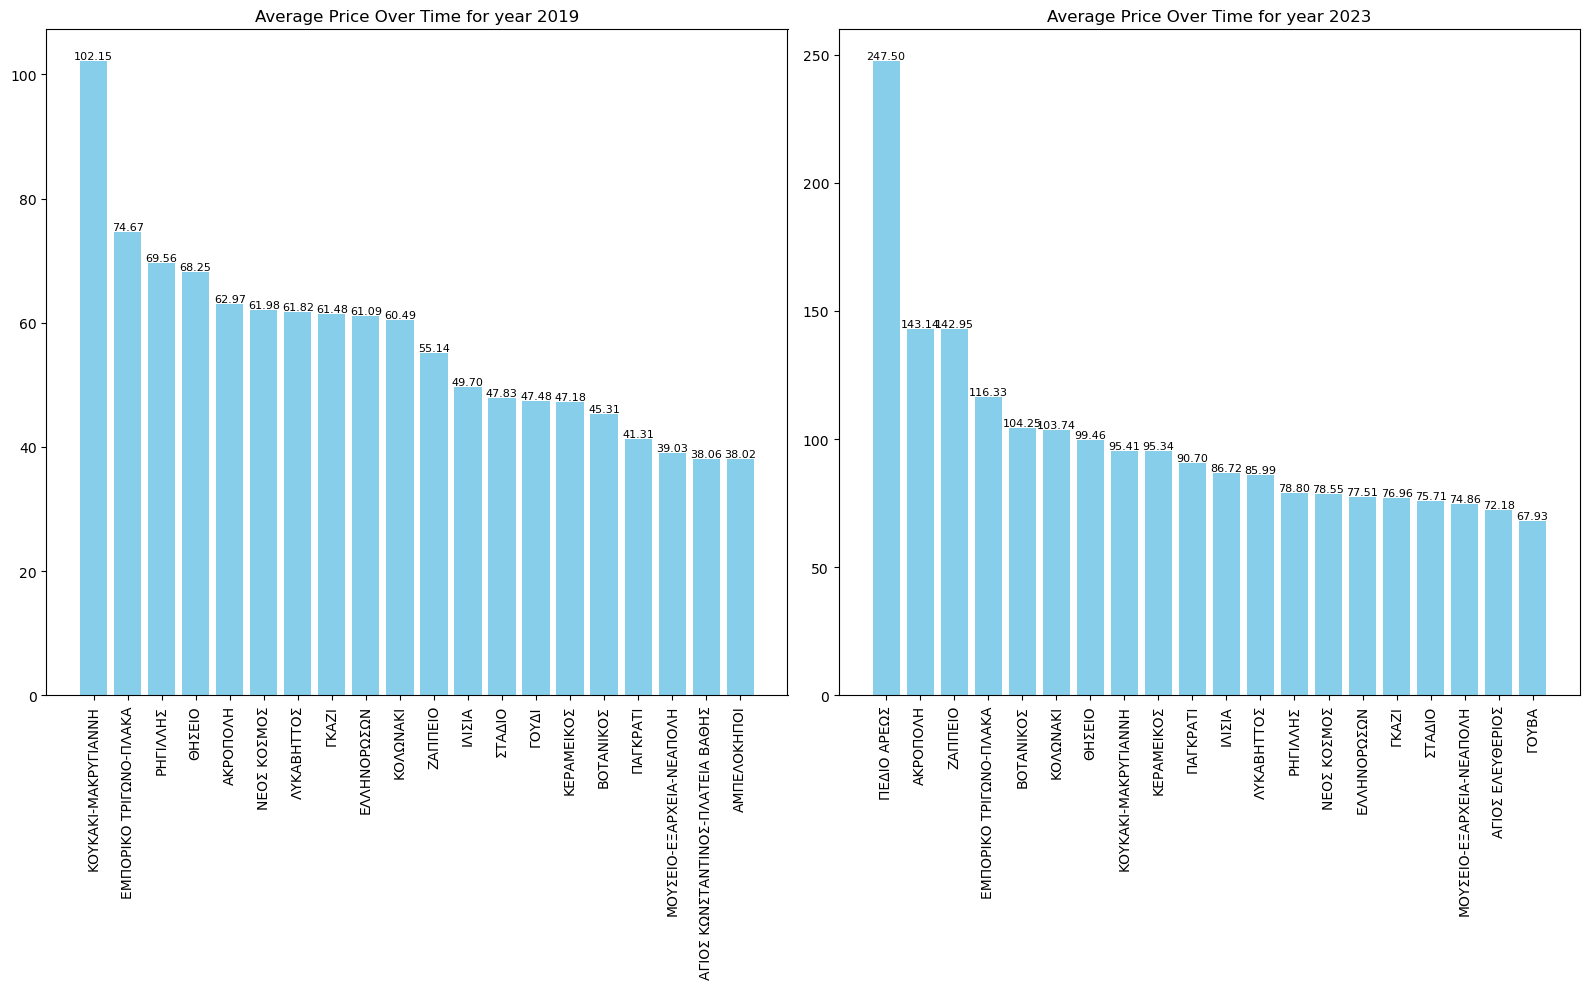

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

i = 0
for year, dataset in working_datasets.items():

    filtered_df = working_datasets[year][working_datasets[year]['bedrooms'] == 1]
    average_price_per_neighborhood = filtered_df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
    average_prices_sorted = average_price_per_neighborhood.sort_values(by='price', ascending=False)
    average_prices_sorted
    top_20_expensive = average_prices_sorted.head(20)

    bars = axs[i].bar(top_20_expensive['neighbourhood_cleansed'], top_20_expensive['price'], color='skyblue')
    axs[i].set_title('Average Price Over Time for year ' + str(year))
    axs[i].set_xticklabels(top_20_expensive['neighbourhood_cleansed'], rotation=90)
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    i=i+1
plt.tight_layout()
plt.show()

#### (1.12)  Show neighbohoods into 3 categories

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\3091952536.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(average_prices_sorted['neighbourhood_cleansed'], rotation=70)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\3091952536.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(average_prices_sorted['neighbourhood_cleansed'], rotation=70)


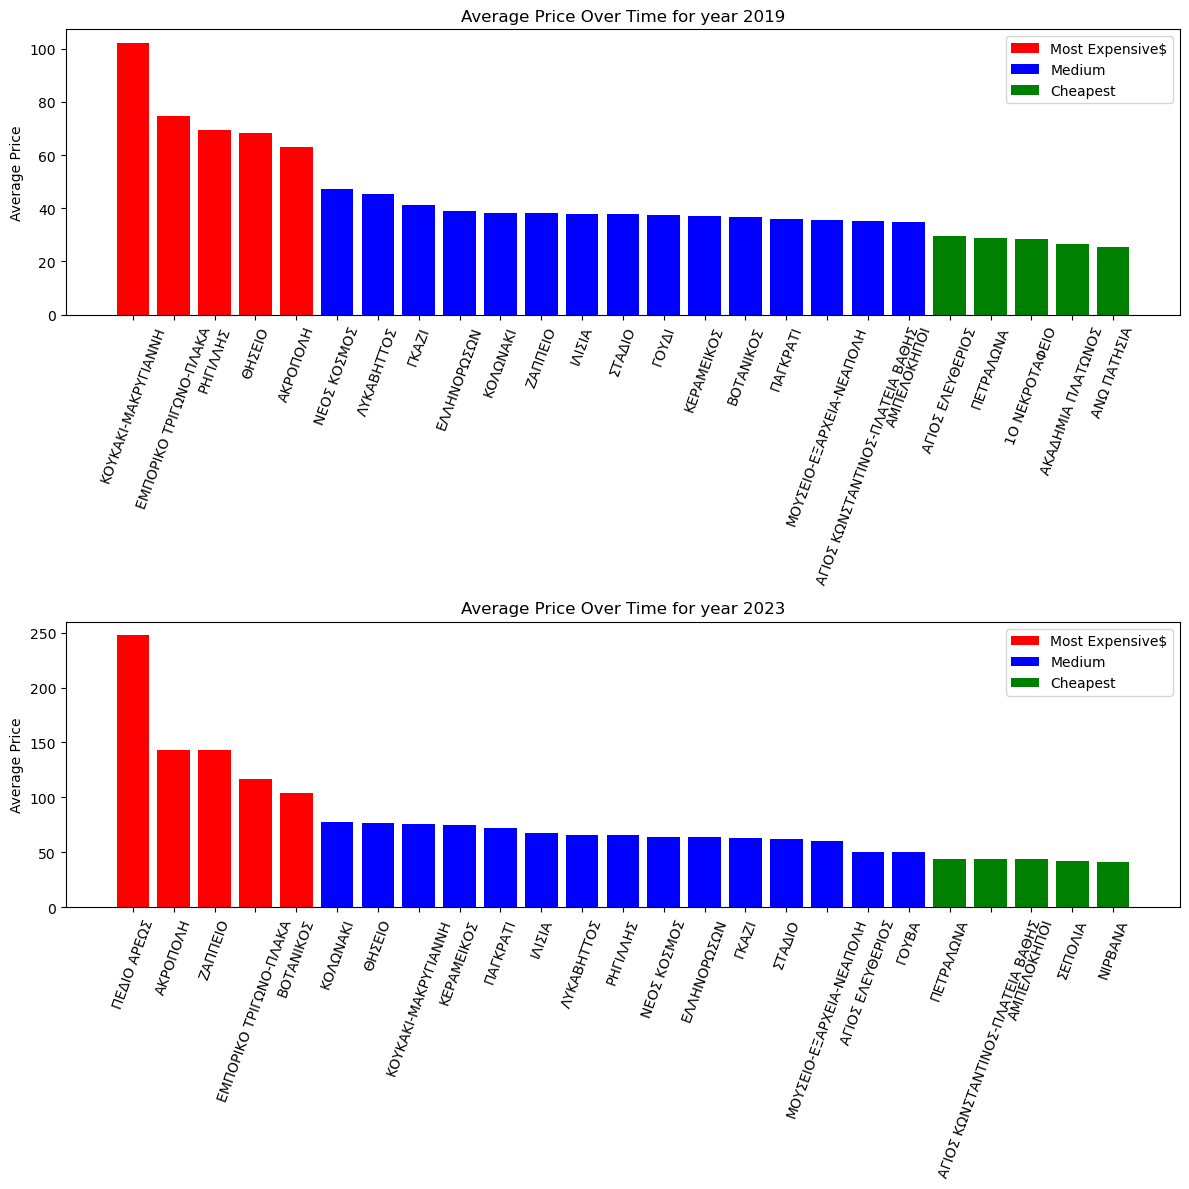

In [96]:
fig, axs = plt.subplots(len(working_datasets), 1, figsize=(12, 6*len(working_datasets)))

# Iterate over each year and its corresponding dataset
for i, (year, dataset) in enumerate(working_datasets.items()):
    filtered_df = dataset[dataset['bedrooms'] == 1]
    average_price_per_neighborhood = filtered_df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
    average_prices_sorted = average_price_per_neighborhood.sort_values(by='price', ascending=False)

    # Divide neighborhoods into most expensive, medium, and cheapest
    top_expensive = average_prices_sorted.head(5)  # Top 5 expensive
    medium = average_prices_sorted.iloc[len(average_prices_sorted)//3:2*len(average_prices_sorted)//3]  # Middle 1/3
    bottom_cheap = average_prices_sorted.tail(5)  # Bottom 5 cheap

    # Plotting as a bar graph
    axs[i].bar(top_expensive['neighbourhood_cleansed'], top_expensive['price'], color='red', label='Most Expensive$')
    axs[i].bar(medium['neighbourhood_cleansed'], medium['price'], color='blue', label='Medium')
    axs[i].bar(bottom_cheap['neighbourhood_cleansed'], bottom_cheap['price'], color='green', label='Cheapest')
    axs[i].set_title('Average Price Over Time for year ' + str(year))
    axs[i].set_xticklabels(average_prices_sorted['neighbourhood_cleansed'], rotation=70)
    axs[i].set_ylabel('Average Price')

    axs[i].legend()

plt.tight_layout()
plt.show()

### (1.13) 
Τα ερωτήματα που αποφασίσαμε να εκτελέσουμε έιναι:\
> Τις 10 γειτονίες με τα καλύτερα review score ratings.\
>  Τα 10 ακίνητα με τα περισσότερα review.\
> Να εμφανίσουμε τις 10 πιο παλίες γειτονίες στην πλατφόρμα.

#### (1.13)  TOP 10  neighbohoods with the highiest review score rating

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\65015399.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_neighborhoods['neighbourhood_cleansed'] , rotation=45)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\65015399.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_neighborhoods['neighbourhood_cleansed'] , rotation=45)


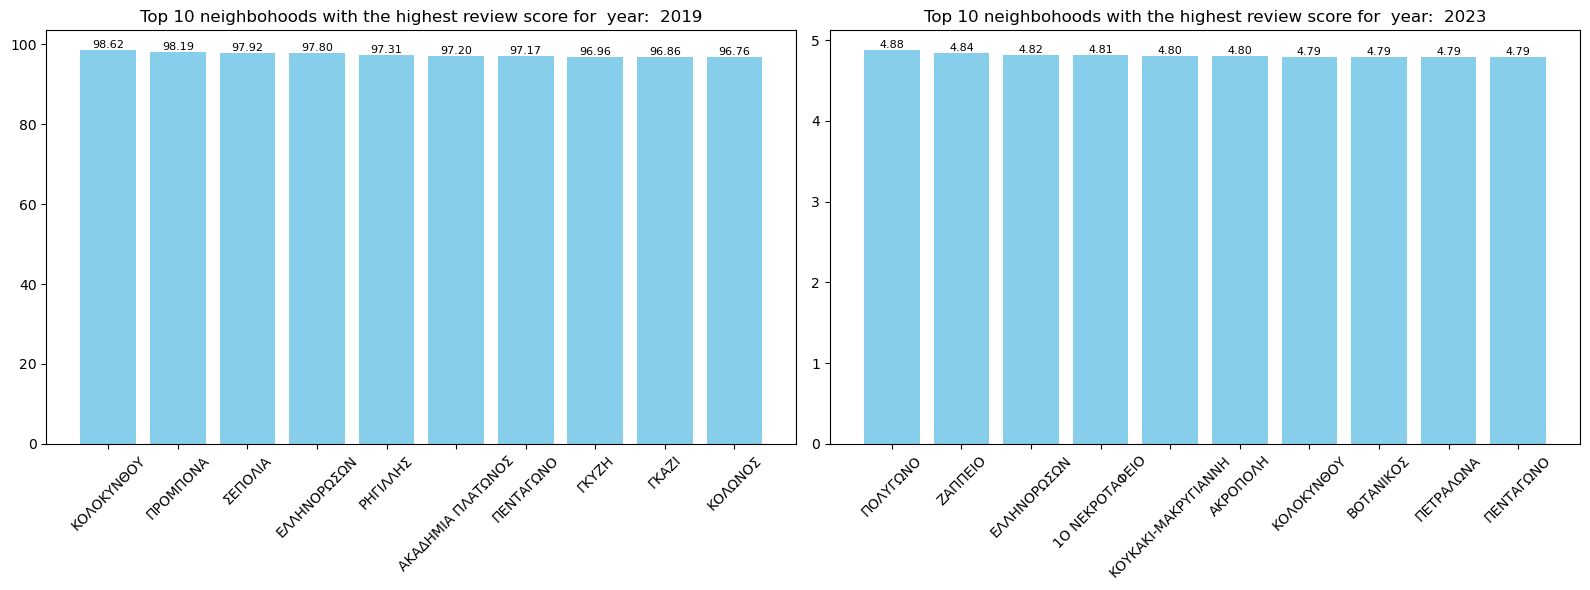

In [97]:
year = "2019"
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for year, dataset in listings_datasets.items():
    top_10_neighborhoods = working_datasets[year].groupby('neighbourhood_cleansed')['review_scores_rating'].mean().nlargest(10).reset_index()
    bars = axs[i].bar(top_10_neighborhoods['neighbourhood_cleansed'], top_10_neighborhoods['review_scores_rating'], color='skyblue')
    axs[i].set_title('Top 10 neighbohoods with the highest review score for  year:  ' + str(year))
    axs[i].set_xticklabels(top_10_neighborhoods['neighbourhood_cleansed'] , rotation=45)
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    i=i+1

plt.tight_layout()
plt.show()

#### (1.13)  Top 10 listings with the most number of reviews
because there are duplicates sort by number of reviews and then drop duplicates

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\3393703991.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_listings['id'] , rotation=45)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\3393703991.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_listings['id'] , rotation=45)


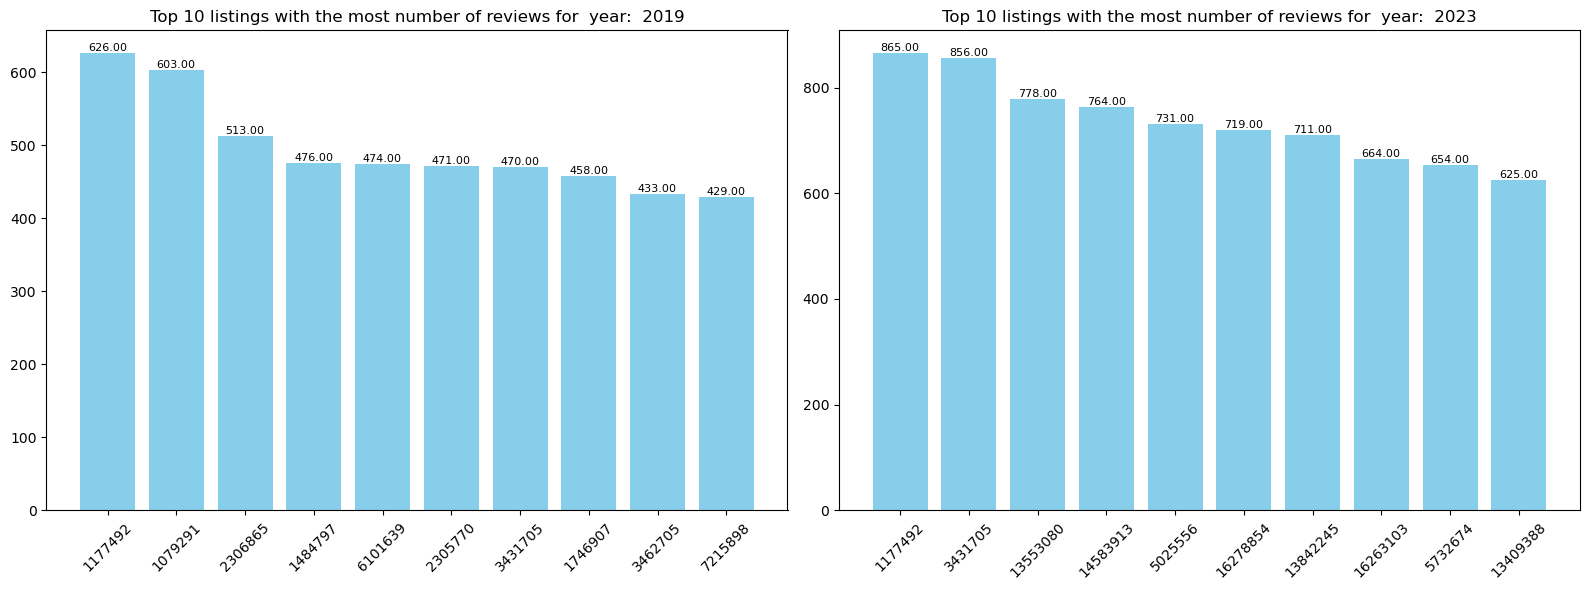

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for year, dataset in listings_datasets.items():
    top_10_listings = working_datasets[year].sort_values(by='number_of_reviews', ascending=False).drop_duplicates(subset='id').head(10)
    top_10_listings['id'] = top_10_listings['id'].astype(str)
    bars = axs[i].bar(top_10_listings['id'], top_10_listings['number_of_reviews'], color='skyblue')
    axs[i].set_title('Top 10 listings with the most number of reviews for  year:  ' + str(year))
    axs[i].set_xticklabels(top_10_listings['id'] , rotation=45)
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    i=i+1

plt.tight_layout()
plt.show()

#### (1.13)  The older neighbohood in the platform

In [99]:
for year, dataset in listings_datasets.items():
    working_datasets[year]['host_since'] = pd.to_datetime(working_datasets[year]['host_since'])
    # working_datasets[year].loc[:, 'host_since'] = pd.to_datetime(working_datasets[year]['host_since'])
    # Group by 'neighbourhood_cleansed' and find the minimum 'host_since' date in each group
    oldest_hosts = working_datasets[year].groupby('neighbourhood_cleansed')['host_since'].min()
    top_5_oldest_neighborhoods = oldest_hosts.nsmallest(5)
    print("Top 5 oldest neighborhoods for year ", str(year) )
    print(top_5_oldest_neighborhoods)
    print("\n")


Top 5 oldest neighborhoods for year  2019
neighbourhood_cleansed
ΑΜΠΕΛΟΚΗΠΟΙ              2009-09-08
ΙΛΙΣΙΑ                   2009-09-08
ΝΕΟΣ ΚΟΣΜΟΣ              2009-10-05
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ   2009-11-28
ΚΟΛΩΝΑΚΙ                 2010-01-15
Name: host_since, dtype: datetime64[ns]


Top 5 oldest neighborhoods for year  2023
neighbourhood_cleansed
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ   2008-08-12
ΑΜΠΕΛΟΚΗΠΟΙ                2009-09-08
ΚΟΛΩΝΑΚΙ                   2010-01-15
ΚΕΡΑΜΕΙΚΟΣ                 2010-04-16
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ     2010-05-09
Name: host_since, dtype: datetime64[ns]




C:\Users\manta\AppData\Local\Temp\ipykernel_18312\4173124913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_datasets[year]['host_since'] = pd.to_datetime(working_datasets[year]['host_since'])
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\4173124913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_datasets[year]['host_since'] = pd.to_datetime(working_datasets[year]['host_since'])


### (1.14)  Show the 10 hosts with the most houses
Έχουμε εκτυπώσει το όνομα μαζί με το ID

C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1348586057.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_hosts['host_name']+" \n"+top_10_hosts['host_id'] , rotation=45)
C:\Users\manta\AppData\Local\Temp\ipykernel_18312\1348586057.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(top_10_hosts['host_name']+" \n"+top_10_hosts['host_id'] , rotation=45)


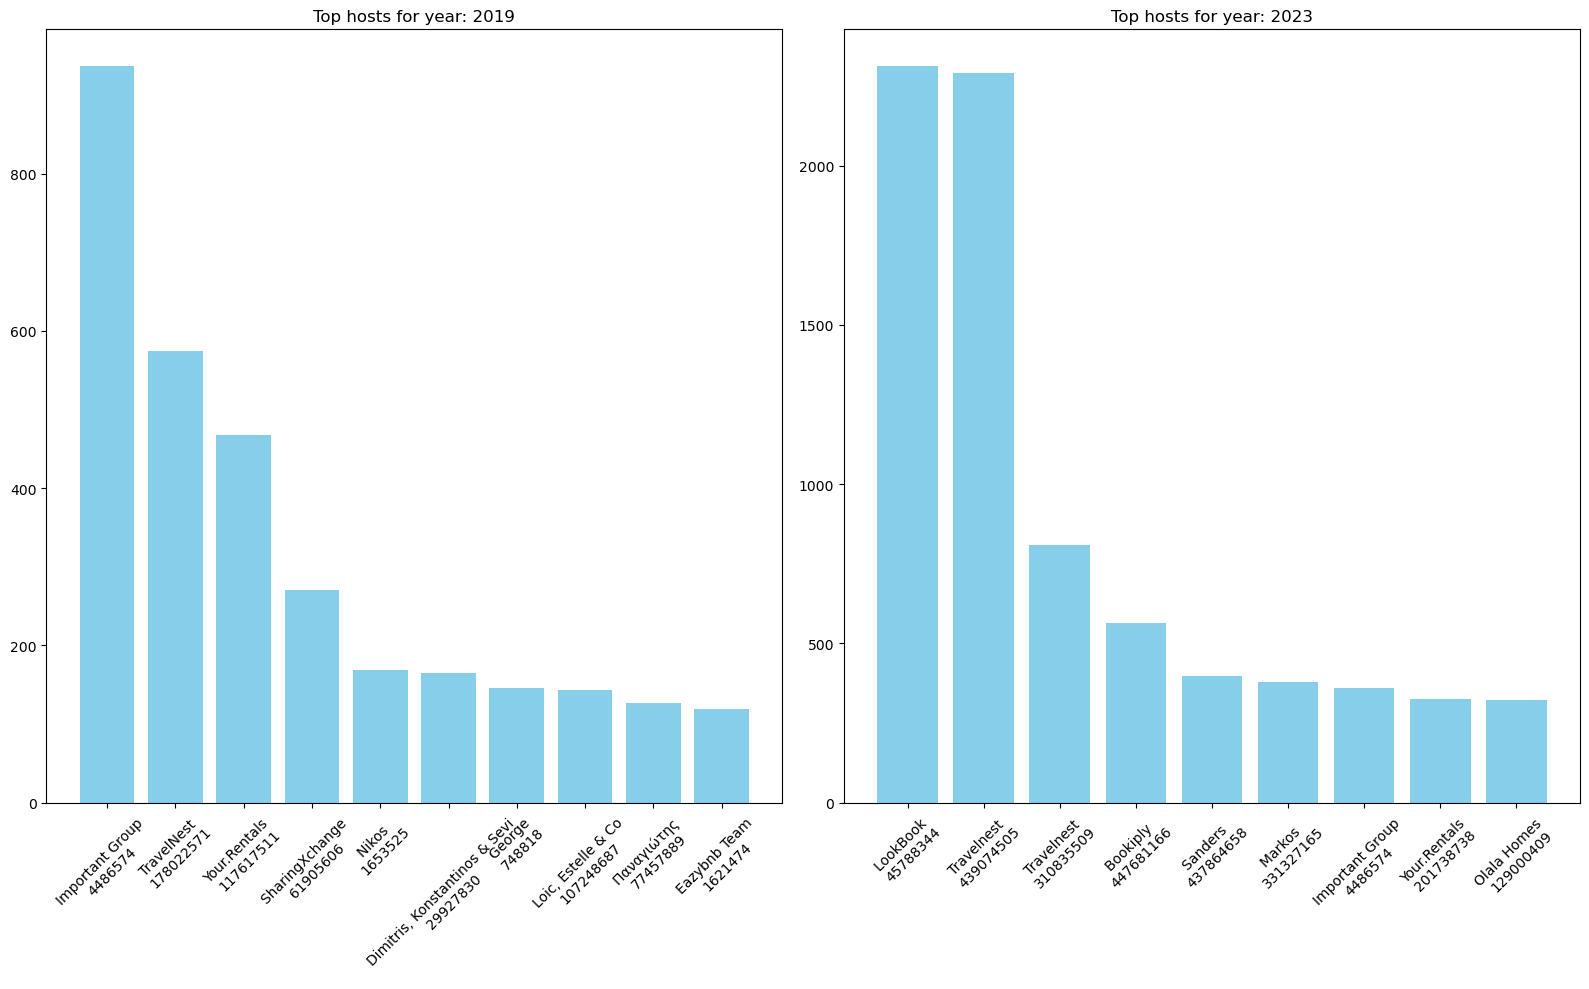

In [100]:
# # top_10_hosts
# plt.figure(figsize=(10, 6))  # Set the size of the figure

# # Plotting the bar graph
# plt.bar(top_10_hosts['host_name'], top_10_hosts['host_listings_count'])

# # Adding labels and title
# plt.xlabel('Host Name')
# plt.ylabel('Listings Count')
# plt.title('Listings Count by Host')

# # Rotating x-axis labels for better readability if needed
# plt.xticks(rotation=45)

# # Show plot
# plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

i = 0
for year, dataset in listings_datasets.items():
    top_10_hosts = listings_datasets[year].sort_values(by='host_listings_count', ascending=False).head(10).reset_index()
    bars = axs[i].bar(top_10_hosts['host_name'], top_10_hosts['host_listings_count'], color='skyblue')
    axs[i].set_title('Top hosts for year: ' + str(year))
    axs[i].set_xticklabels(top_10_hosts['host_name']+" \n"+top_10_hosts['host_id'] , rotation=45)

    i=i+1
plt.tight_layout()
plt.show()

### (1.15) Συμπεράσματα.
Και στις δύο χρονιές ο πιο συχνός τύπος airbnb είναι το ολόκληρο σπίτι/διαμέρισμα. Παρατηρούμε μια μικρή μείωση της τάξης του 2.8% στην επιλογή ιδιωτικού δωματίου και επίσης το 2023 εμφανίζεται και η επιλογή για δωμάτιο ξενοδοχείου.

Η μέση τιμή είναι υψηλότερη τον Ιούνιο του 2023 και χαμηλότερη τον Απρίλη του 2019. Επίσης η μέση τιμή Μρτίου αυξάνεται  κατά 33.7% από το 2019 στο 2023.

Τα περισσότερα reviews τα έχει η περιοχή “Εμπορικό τρίγωνο-Πλάκα” και τις δύο χρονιές. Ενώ οι πέντε περιοχές με τα περισσότερα reviews παραμένουν σταθερές, παρατηρούμε σχεδόν διπλασιασμό reviews για την κάθε μια το έτος 2023 σε σχέση με το 2019.

Οι πέντε περιοχές με τα περισσότερα listings παραμένουν ίδιες μεταξύ των δύο ετών. Υπάρχει ωστόσο μια αύξηση 5.4% στην πρώτη σε ποσοστό περιοχή “Εμπορικό τρίγωνο-Πλάκα”, η οποία φαίνεται να έχει αφαιρεθεί ισόποσα από τις υπόλοιπες τέσσερις περιοχές.

Στα διαγράμματα με τα listings ανά μήνα σε κάθε περιοχή παρατηρούμε ότι τα περισσότερα listings τα έχουν οι περιοχές που είδαμε και στα αμέσως προηγούμενα διαγράμματα. Επίσης τα listings ανά μήνα φαίνονται να είναι ίσα πληθικά, δηλαδή 33% και 33% και 33%. Αξίζει να σημειωθεί ότι το 2023 υπάρχει αύξηση των listings περίπου κατά 50%.

Τόσο το 2019 όσο και το 2023, ο πιο συχνός τύπος airbnb σε όλες τις περιοχές είναι το ολόκληρο σπίτι/διαμέρισμα. Φαίνεται βέβαια ξανά και σε αυτό το διάγραμμα η αύξηση ανά περιοχή κατά 50%.

Όσον αφορά τις τιμές υπάρχουν αρκετές διαφορές. Το 2019 ο πιο ακριβός τύπος airbnb ήταν το ιδιωτικό δωμάτιο 7000$, ενώ το 2023 ήταν το ολόκληρο σπίτι/διαμέρισμα 80275$. Το 2019 το δεύτερο υψηλότερο σε κόστος ήταν το ολόκληρο σπίτι/διαμέρισμα 7000$, ενώ το 2023 ήταν το δωμάτιο ξενοδοχείου και το ιδιωτικό δωμάτιο και με τα δύο να βρίσκονται στις 8000$. Επιπλέον το 2023 εμφανίζεται και το δωμάτιο ξενοδοχείου.
Εντυπωσιακή είναι η αύξηση της τιμής στο ολόκληρο σπίτι/διαμέρισμα κατά 75275$. Το ιδιωτικό δωμάτιο αυξήθηκε κατά 1000$, ενώ το shared δωμάτιο παραμένει η πιο οικονομική λύση, ακόμα και μετά την αύξηση 197$ που το έφερε στα 797$.

Από τα wordclouds για τις διάφορες περιοχές βγάζουμε το ίδιο συμπέρασμα για τις πρώτες πέντε, όπως και από τα προηγούμενα διαγράμματα. Εμπορικό τρίγωνο-Πλάκα, Κουκάκι-Μακρυγιάννη, Μουσείο-Εξάρχεια-Νεάπολη, Νέος Κόσμος και Άγιος Κωνσταντίνος-Πλατεία Βάθης.\

Στο διάγραμμα με τα keyword frequencies αυτό που αξίζει να σημειωθεί είναι η αύξηση που έχει ο Νέος Κόσμος το 2023 σε σχέση με το 2019. Κατά τα άλλα η πορεία είναι φθίνουσα και οι πρώτες πέντε περιοχές οι ίδιες με τα προηγούμενα.

Στα διαγράμματα με τις πιο συχνά χρησιμοποιούμενες λέξεις στις περιγραφές των listings παρατηρούμε τις apartment, athens, located, fully, equipped, room, one, acropolis, metro. Από τα συμφραζόμενα καταλαβαίνουμε ότι ο περισσότερος κόσμος ψάχνει ένα διαμέρισμα, πλήρες εξοπλισμένο, με ένα υπνοδωμάτιο, κοντά στην Ακρόπολη και με εύκολη πρόσβαση στο μετρό. Τι πιο αναμενόμενο.

Στα διαγράμματα με τις πιο συχνά χρησιμοποιούμενες λέξεις στις αξιολογήσεις υπάρχουν οι λεξεις apartment, nice, great, location, stay, place. Με άλλα λόγια “Nice place to stay, great location” είναι η πιο συχνή κριτική. 

Από το διάγραμμα με τα amenities μπορούμε να συμπεράνουμε ότι οι βασικές κατηγορίες είναι η ύπαρξη κουζίνας με κάποια βασικά σκεύη, το “Electricity and Technology” όπως wifi, air continioning, τηλεόραση, “facilities” τύπου ζεστό νερό, πιστολάκι για τα μαλλιά, κρεμάστρες και θέρμανση, το να είναι ο χώρος φιλικός για παιδιά, η προσβασιμότητα για άτομα με αναπηρία και η ασφάλεια της τοποθεσίας. Σεντόνια, μαξιλάρια, σαπούνι κτλ μπαίνουν στην κατηγορία other που είναι και αυτή μια από τις βασικές.

Η μέση τιμή ανά χρόνο βλέπουμε πως έχει αυξηθεί για κάθε περιοχή από το 2019 στο 2023.  Οι πρώτες πέντε περιοχές το 2019 ήταν Κουκάκι-Μακρυγιάννη, Εμπορικό τρίγωνο-Πλάκα, Ρηγίλλης, Θησείο και Ακρόπολη. Το 2023 η πρώτη πεντάδα διαμορφώνεται ως Πεδίο Άρεως, Ακρόπολη, Ζάππειο, Εμπορικό τρίγωνο-Πλάκα, Βοτανικός. Αξιοσημείωτο είναι ότι η μέση τιμή ανά χρόνο της πρώτης περιοχής διπλασιάζεται το 2023.

Γενικά οι τάξεις μέσης τιμής ανά έτος διαμορφώνονται με το 20% να είναι οι πιο υψηλές, το 60% να κυμαίνονται στη μέση και το άλλο 20% να είναι στις χαμηλές τιμές.

Οι περιοχές με τις καλύτερες κριτικές αλλάζουν δραματικά μεταξύ των δύο χρονών. Οι μόνες που βρίσκουμε στα top 10 και τις δύο φορές είναι το Πεντάγωνο και η Ελληνορώσων.

Στα top 10 listings με τις περισσότερες αξιολογήσεις βρίσκουμε και τις δύο χρονιές το 1177492 και το 3431705. Όλα τα υπόλοιπα είναι διαφορετικα μεταξύ των δύο. Να σημειωθεί ότι σε πλήθος αξιολογήσεων υπάρχει μεγάλη αύξηση σε όλα τα istings το 2023.

Στους top 10 οικοδεσπότες βρίσκουμε και τις δύο χρονιές το 4496574, αν και το 2023 έχει πέσει από την πρώτη θέση στην έβδομη. Παρατηρούμε επιπλέον ότι οι πρώτοι δύο οικοδεσπότες σε κάθε χρονιά έχουν μεγάλη απόκλιση από όλους τους υπόλοιπους. Είναι φανερό επίσης ότι το 2023 έχουν διπλασιαστεί τα listings για κάθε οικοδεσπότη.


## Recommendation system

### Preprocessing

In [101]:
year = '2019'
dataset = working_datasets[year][["id", "name", "description"]]

mystopwords = STOPWORDS

mystopwords.add("b")
mystopwords.add("br")
# add more stop words ...

entries = [str(r).replace("-", " ") for r in dataset["description"] if r != None]

text_data = ' '.join(entries) 

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=mystopwords).generate(text_data)

#### Visualize desctription removing stopwords with word cloud

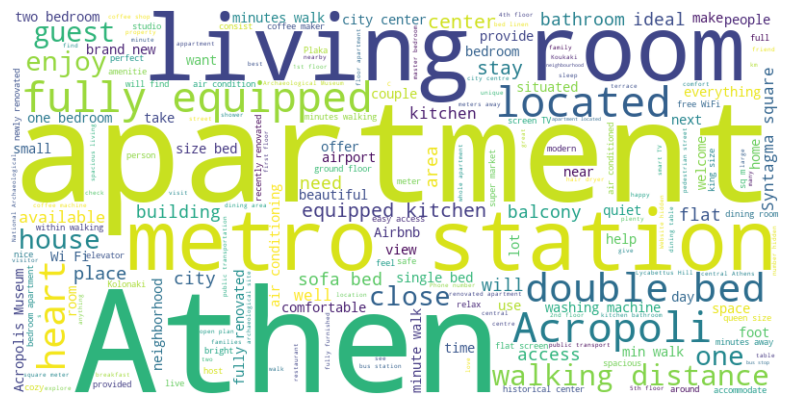

In [102]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Visualize stopwords with histogram

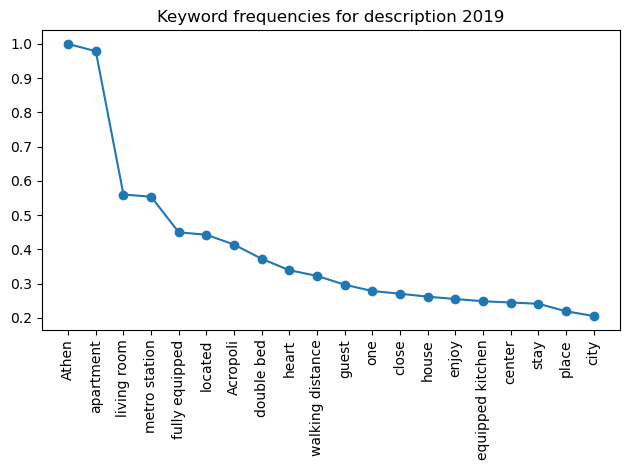

In [103]:
word_frequencies = wordcloud.words_

sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(sorted_word_frequencies[:20], columns=['Keyword', 'Frequency'])

df.set_index('Keyword', inplace=True)

plt.plot(df.index, df['Frequency'], marker='o')
plt.title('Keyword frequencies for description ' + str(year))
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

#### Remove rows with greek words in attributes

In [104]:
def contains_greek(text):
    if text == None:
        return False
    
    text = str(text)
    greek_pattern = re.compile('[\u0370-\u03FF\u1F00-\u1FFF]+')  # Range of Greek characters in Unicode
    return bool(greek_pattern.search(text))

print("Initial shape:" , dataset.shape)

df_filtered = dataset[~dataset['name'].apply(contains_greek)]

print("Remove rows with greek words in name:" , df_filtered.shape)

df_filtered = dataset[~dataset['description'].apply(contains_greek)]

print("Remove rows with greek words in description:" , df_filtered.shape)


Initial shape: (28122, 3)
Remove rows with greek words in name: (27175, 3)
Remove rows with greek words in description: (24521, 3)


#### Add keywords column

In [105]:
df_filtered.loc[:,'keywords'] = (df_filtered.loc[:,'name'] + ' ' + df_filtered.loc[:,'description']).str.lower()

print("Listings: ", df_filtered.shape)

Listings:  (24521, 4)


C:\Users\manta\AppData\Local\Temp\ipykernel_18312\955367242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:,'keywords'] = (df_filtered.loc[:,'name'] + ' ' + df_filtered.loc[:,'description']).str.lower()


Convert column keywords to python string:

In [106]:
df_filtered.loc[:,'keywords'] = df_filtered.loc[:,'keywords'].astype('string')

print(df_filtered.dtypes)

id              int64
name           object
description    object
keywords       object
dtype: object


Fill NA with empty string:

In [107]:
df_filtered.loc[:,'keywords'] = df_filtered.loc[:,'keywords'].fillna('')

Καθαρίζουμε τα δεδομένα όπως αφαιρούμε αφαιρούμε emojis, σημέια στήξης, αριθμούς, διπλά κενά, html tags, τα δεδομένα που αφορούν τα τετραγωνικά\
που έχουν την μορφή ddm2, και stopwords\
θα μπορούσαμε να το κάνουμε αυτό με την βιβλιοθήκη nltk αλλά δεν θέλαμε να περάσουμε στον κώδικά μας άλλες εξωτερικές βιβλιοθήκες που πρέπει να κατανάσουμε train data\ 
για να έχουμε το ίδιο αποτέλεσμα


In [108]:
CLEANR = re.compile('<.*?>') #remove html tags
pattern = r'\b\d+m2\b' # remove apartment size
special = r'[-!@#$%^&*()_+={}\[\]:;"\'|<,>.?/~`]' # remove special character
symbols = re.compile("["
                     u"\U0001F600-\U0001F64F"  # Emoticons
                     u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                     u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                     u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                     u"\U00002500-\U00002BEF"  # Chinese/Japanese/Korean characters
                     u"\U00002702-\U000027B0"
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     u"\U0001f926-\U0001f937"
                     u"\U00010000-\U0010ffff"
                     u"\u2640-\u2642"
                     u"\u2600-\u2B55"
                     u"\u200d"
                     u"\u23cf"
                     u"\u23e9"
                     u"\u231a"
                     u"\ufe0f"  # dingbats
                     u"\u3030"
                     "]+", re.UNICODE)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in STOPWORDS]
    return ' '.join(filtered_words)

def cleanUp(field):
    if field == None:
        return ""
    field = field.lower()
    field = re.sub(CLEANR, ' ', field)
    field = re.sub(r'[^\w\s]', ' ', field) # Remove punctuation
    field = re.sub(r'\d+', ' ', field) # Remove digits
    field = re.sub(r'\s+', ' ', field).strip() # Remove extra whitespaces
    field = re.sub(r'\b\w\b', ' ', field) # Remove single letters
    field = re.sub(pattern, ' ', field) #remove appartment sizes
    field = re.sub(r'\b\w{2}\b', ' ', field) #remove 2 letter words
    field = re.sub(symbols, '', field)
    field = re.sub(special, '', field)
    field = remove_stopwords(field)
    return field

for index, row in df_filtered.iterrows():
    # x = cleanUp(str(row['keywords']))    
    df_filtered.at[index, 'keywords'] = cleanUp(row['keywords'])


Review the first 10 rows:

In [109]:
df_filtered[:10]
df_filtered.iloc[86]

id                                                        502842
name                         1 bedrm apt, terrace, walk to Plaka
description    Apartment located in a fully renovated Bauhaus...
keywords       bedrm apt terrace walk plaka apartment located...
Name: 90, dtype: object

## TF/IDF

### TF-IDF weight matrix

In [110]:
unigram_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    strip_accents='unicode',
    stop_words='english'
)

bigram_vectorizer = TfidfVectorizer(
    ngram_range=(2, 2), 
    strip_accents='unicode',
    stop_words='english'
)

### Training
Printing the stats to see how well our clean up is.

In [111]:
print("Calculating weights for unigrams for year " ,year, " ... ")

unigram_matrix = unigram_vectorizer.fit_transform(df_filtered['keywords'])

print("Calculating weights for bigrams for year " ,year, " ... ")

bigram_matrix = bigram_vectorizer.fit_transform(df_filtered['keywords'])

print("Unigrams (shape) : " , unigram_matrix.shape)
print("Bigrams  (shape) : " , bigram_matrix.shape)
print("Documents        : " , unigram_matrix.shape[0])
print("Unigrams         : " , unigram_matrix.shape[1])
print("Bigrams          : " , bigram_matrix.shape[1])


Calculating weights for unigrams for year  2019  ... 
Calculating weights for bigrams for year  2019  ... 
Unigrams (shape) :  (24521, 17945)
Bigrams  (shape) :  (24521, 194477)
Documents        :  24521
Unigrams         :  17945
Bigrams          :  194477


#### Print some unigrams for testing:

In [112]:
list(unigram_vectorizer.vocabulary_.keys())[:10]

['metro',
 'athens',
 'furnished',
 'apartment',
 'bedroom',
 'bathrooms',
 'excellent',
 'located',
 'close',
 'station']

#### Print some bigrams for testing:

In [113]:
list(bigram_vectorizer.vocabulary_.keys())[:10]

['metro athens',
 'athens furnished',
 'furnished apartment',
 'apartment bedroom',
 'bedroom apartment',
 'apartment bathrooms',
 'bathrooms excellent',
 'excellent located',
 'located close',
 'close metro']

### Document - Document distance matrix

In [114]:
print("Calculating similarity matrix for unigrams for year " ,year, " ... ")

unigram_similarities = cosine_similarity(unigram_matrix)

print("Unigram similarity matrix dimensions: ", unigram_similarities.shape)

Calculating similarity matrix for unigrams for year  2019  ... 
Unigram similarity matrix dimensions:  (24521, 24521)


In [115]:
print("Calculating similarity matrix for bigrams for year " ,year, " ... ")

bigram_similarities = cosine_similarity(bigram_matrix)


print("Bigram  similarity matrix dimensions: ", bigram_similarities.shape)

Calculating similarity matrix for bigrams for year  2019  ... 
Bigram  similarity matrix dimensions:  (24521, 24521)


In [116]:
unigram_similarities

array([[1.        , 0.72989626, 0.81966896, ..., 0.09466459, 0.09991794,
        0.00461583],
       [0.72989626, 1.        , 0.76693804, ..., 0.06386851, 0.06248526,
        0.00386957],
       [0.81966896, 0.76693804, 1.        , ..., 0.08513007, 0.08257765,
        0.00739803],
       ...,
       [0.09466459, 0.06386851, 0.08513007, ..., 1.        , 0.9872862 ,
        0.00642105],
       [0.09991794, 0.06248526, 0.08257765, ..., 0.9872862 , 1.        ,
        0.00592161],
       [0.00461583, 0.00386957, 0.00739803, ..., 0.00642105, 0.00592161,
        1.        ]])

In [117]:
bigram_similarities

array([[1.        , 0.64336405, 0.67198577, ..., 0.00154085, 0.00150532,
        0.        ],
       [0.64336405, 1.        , 0.75710245, ..., 0.00745064, 0.00727884,
        0.        ],
       [0.67198577, 0.75710245, 1.        , ..., 0.00929149, 0.00907723,
        0.        ],
       ...,
       [0.00154085, 0.00745064, 0.00929149, ..., 1.        , 0.94161009,
        0.        ],
       [0.00150532, 0.00727884, 0.00907723, ..., 0.94161009, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### Select a subset of the similarity matrix
Επειδή τα δεδομένα είναι πάρα πολλά έχουμε χρησιμοποίηση την μεταβλήτή ration όπου μπορούμε να επιλέξουμε μόνο ενα μέρος των δεδομένων.

Select 5% of the original dataset:\
Select bigram or unigram by changing the line siliarities cropped


In [118]:
ratio = 0.05
rows = round(unigram_similarities.shape[0]*ratio)

# rows = 20
# change to bugram or unigram
similarities_cropped = unigram_similarities[:rows,:rows] 
# similarities_cropped = bigram_similarities[:rows,:rows]

similarities_cropped.shape

(1226, 1226)

In [119]:
print("    Listing 2: ", df_filtered.iloc[17]['id'], df_filtered.iloc[17]['name'])

    Listing 2:  79423 Stay in the centre of Athens (5min)


### Top 100 similar

Στην μεταβλητή topN περνάμε το πόσα παρόμοια ακίνητα θέλουμε να βρούμε.
Τρόπος εύρεσης παράμοιών listings: Φτιάχνουμε μια μνήμη και έναν πίνακα Ν θέσεων διασχίζουμε τον κάτω τριγωνικό tuple\ 
για κάθε μέγιστο που βρήσκουμε αν δεν είναι στην μνήμη άρα δεν το έχουμε ξανα-επισκεφτεί τότε το προσθέτουμε στον tuple.\
Τέλος εκτυπώνουμε τον tuple.


In [120]:
topN = 100

cache = set()
results = {}

for i in range(rows):
    cache.add((i,i))

for n in range(topN):
    max_similarity = -1
    max_coords = None

    for i in range(rows):
        for j in range(i):
            coords = (i,j)
            if coords in cache:
                continue
            value = similarities_cropped[i,j]

            if value > max_similarity:
                max_similarity = value
                max_coords = coords

    if max_similarity != -1:
        results[n] = (max_coords[0], max_coords[1], max_similarity)
        cache.add(max_coords)

print("                                Top pairs: ")

for key, value in results.items():
    print("Top:", key, "Listing index:", value[0], value[1], "Similarity:", value[2])

    print("    Listing 1: ", df_filtered.iloc[value[0]]['id'], df_filtered.iloc[value[0]]['name'])
    print("    Listing 2: ", df_filtered.iloc[value[1]]['id'], df_filtered.iloc[value[1]]['name'])

    

                                Top pairs: 
Top: 0 Listing index: 963 962 Similarity: 1.0000000000000002
    Listing 1:  9648354 chameleon youth hostel doorms
    Listing 2:  9648099 chameleon youth hostel doorms
Top: 1 Listing index: 237 209 Similarity: 1.0
    Listing 1:  1473469 Athens2-Feel it like your own space
    Listing 2:  1223199 Athens1-Feel it like your own space
Top: 2 Listing index: 1169 1166 Similarity: 0.9999999999999999
    Listing 1:  11559962 Deluxe Apt 3 - Center of Athens
    Listing 2:  11542772 Deluxe  Apt 1 - Center of Athens
Top: 3 Listing index: 1170 1166 Similarity: 0.9999999999999999
    Listing 1:  11562618 Deluxe Apt 2 - Center of Athens
    Listing 2:  11542772 Deluxe  Apt 1 - Center of Athens
Top: 4 Listing index: 1170 1169 Similarity: 0.9999999999999999
    Listing 1:  11562618 Deluxe Apt 2 - Center of Athens
    Listing 2:  11559962 Deluxe Apt 3 - Center of Athens
Top: 5 Listing index: 114 64 Similarity: 0.9954210408827656
    Listing 1:  650687 Bed &

### Recommendation function
Χρησιμοποιούμε την ίδια νοοτροπία με το παραπάνω ερώτημα μόνο που εδώ κοιτάμε μόνο την στήλη για το  listing που ψάχνουμε.

In [121]:

def recommend(listing_id, num = 5):
    index = df_filtered[df_filtered['id'] == listing_id].index[0]

    cache = set()
    results = {}

    for i in range(rows):
        cache.add((i,i))

    for n in range(num + 1):
        max_similarity = -1
        max_coords = None

        i = index
        for j in range(rows):
            coords = (i,j)
            if coords in cache:
                continue
            value = similarities_cropped[i,j]

            if value > max_similarity:
                max_similarity = value
                max_coords = coords

        if max_similarity != -1:
            results[n] = (max_coords[0], max_coords[1], max_similarity)
            cache.add(max_coords)

    print("                                Similar listings to: ", listing_id)

    for key, value in results.items():
        # print("    " , key + 1, "Listing ID: ", df_filtered.iloc[value[1]]['id'], "\n Recommended:",working_datasets['2019'].iloc[value[1]]['name'],'\n Description:',working_datasets['2019'].iloc[value[1]]['description'], '\n'," score: ", value[2])
        print("Recommended:",working_datasets['2019'].iloc[value[1]]['name'],'\nDescription:',working_datasets['2019'].iloc[value[1]]['description'], '\nscore: ({:03f})'.format(value[2]))


# Find top 10 listings similar to 10995
listing_id = 10995

recommend(listing_id, 10)

                                Similar listings to:  10995
Recommended: 50m2, Metro, WI-FI, cableTV, more 
Description: Athens Furnished Apartment No3 is 1-bedroom apartment (50 square meters)  -excellent located  -close to metro station,  -lovely,  -very clean  with all the facilities that you will need, nice balcony, excellent Wi-Fi, cable tv, fully air conditioned… Athens Furnished Apartment No3 is an excellent located, close to metro, lovely, very clean 1-bedroom apartment (50 square meters) with all the facilities that you will need and a very nice balcony facing the inner garden to enjoy your breakfast in the morning or relax in the evening. Fully equipped kitchen with everything you need to prepare your lunch/dinner. Nice Living room to relax and enjoy a movie or a sport event. Clean nice bathroom. For more than 2 people there is a great double sofa/bed in the living room. Apartment No3 has everything you will need. -Telephone line for incoming calls or to call us if you need s

In [122]:
df_filtered.head(20)

id                                               name  \
0   10595                96m2, 3BR, 2BA, Metro, WI-FI etc...   
1   10988                 75m2, 2-br, metro, wi-fi, cable TV   
2   10990                  50m2, Metro, WI-FI, cableTV, more   
3   10993                Studio, metro, cable tv, wi-fi, etc   
4   10995                47m2, close to metro,cable TV,wi-fi   
5   27262                 54m2, 1-br, cable tv, wi-fi, metro   
6   28186             ❤️Deluxe central loft near Acropolis❤️   
7   31155                              sleep on sailing boat   
8   33704   Artist's studio in Athens, safe area, near metro   
9   38100                Stay at the heart of Athens (100m²)   
10  40149                 Great View - Heart of Athens  wifi   
11  44858        Luxury room near Areos Park & Athens centre   
12  48635                Athensstay!Welcome home!metroAttiki   
13  49489                    3bdr apt in the heart of Athens   
14  54637                 Penthouse Parthenon view in Athens   
15  59663                 ATHENS spacious apt Ideal location   
16  60394  Cosy 1 bedroom apt! Great central Athens locat...   
18  79423                Stay in the centre of Athens (5min)   
20  81230                Chroma apt - Traveling on a budget?   
21  82239                       Charming 1BR near Acropolis!   

                                          description  \
0   Athens Furnished Apartment No6 is 3-bedroom ap...   
1   Athens Furnished Apartment No4 is 2-bedroom ap...   
2   Athens Furnished Apartment No3 is 1-bedroom ap...   
3   The Studio is an  -excellent located  -close t...   
4   AQA No2 is 1-bedroom apartment (47m2)  -excell...   
5   Big 1-bedroom apartment that can accommodate 4...   
6   TOP 5 REASONS to stay here ⭐️Don't waste your ...   
7   on beautiful island of Aigina, 30 minutes from...   
8   Airport metro line (4min walk to station) Safe...   
9   Located in one of the most luxurious and safer...   
10  Recently refurbished apartment, 3 minutes away...   
11  Important: If your rating for cleaning is not ...   
12  Simple apartment for maximum 4people. Next to ...   
13  Fully furnished, 98 sq.mt., apartment on 44 Er...   
14  Art penthouse, with a stunnng view in Acropoli...   
15  - Located at Larissis metro station on central...   
16  Fully furnished cozy apartment in the best nei...   
18  A great place for those who are looking for a ...   
20  Chroma apt is our spare apartment in Athens an...   
21  Newly renovated apartment with 1 bedroom (larg...   

                                             keywords  
0   metro etc athens furnished apartment bedroom a...  
1   metro cable athens furnished apartment bedroom...  
2   metro cabletv athens furnished apartment bedro...  
3   studio metro cable etc studio excellent locate...  
4   close metro cable aqa bedroom apartment excell...  
5   cable metro big bedroom apartment accommodate ...  
6   deluxe central loft near acropolis top reasons...  
7   sleep sailing boat beautiful island aigina min...  
8   artist studio athens safe area near metro airp...  
9   stay heart athens located one luxurious safer ...  
10  great view heart athens wifi recently refurbis...  
11  luxury room near areos park athens centre impo...  
12  athensstay welcome home metroattiki simple apa...  
13  bdr apt heart athens fully furnished apartment...  
14  penthouse parthenon view athens art penthouse ...  
15  athens spacious apt ideal location located lar...  
16  cosy bedroom apt great central athens location...  
18  stay centre athens min great place looking nea...  
20  chroma apt traveling budget chroma apt spare a...  
21  charming near acropolis newly renovated apartm...